In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install astroNN

     |████████████████████████████████| 9.3 MB 29.9 MB/s 
     |████████████████████████████████| 4.5 MB 55.3 MB/s 
     |████████████████████████████████| 832 kB 44.0 MB/s 
     |████████████████████████████████| 48 kB 7.3 MB/s 
     |████████████████████████████████| 4.0 MB 34.9 MB/s 
  Created wheel for astroNN: filename=astroNN-1.0.1-py3-none-any.whl size=9284595 sha256=edd87476cd2b2aadfb3a0585b70dee3213406165be2f7d2f38494232f63d68b5
  Stored in directory: /root/.cache/pip/wheels/26/a4/7e/4cbf2a7f9cd51929da9d09345e8cd37c647b54825a1314dd2d
Successfully built astroNN


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import random
random.seed(42)
import joblib

import cv2
from PIL import Image
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Rescaling, Resizing, RandomFlip, RandomRotation , RandomCrop, RandomTranslation, RandomZoom, RandomHeight, RandomWidth, RandomContrast
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras import utils
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras.callbacks import EarlyStopping

import h5py

from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#loading the file instead of from the model (which is crashing my computer)
import astroNN
from astroNN.datasets import galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup, galaxy10_confusion

WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9006112553175539273
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13080085368289990462
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [6]:
# To load images and labels (will download automatically at the first time)
# First time downloading location will be ~/.astroNN/datasets/
from astroNN.datasets import load_galaxy10 

images, labels = load_galaxy10()   #this has the same amount of classified image data just like galaxy10.load_data()!!

labels

#BEFORE CONVERTING THEM.. THE ORIGINAL DATASET IS IN UINT8 TYPE!!!!
# To convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

/root/.astroNN/datasets/Galaxy10.h5 was found!


In [6]:
#offline data augmentation

In [7]:
#function to visualize and compare the original and augmented images side-by-side:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

In [8]:
import os, os.path

In [9]:
for i in range(10):
  DIR = f'/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/Galaxy10/class_{i}'
  print(f"Amount of Class {i} images: {len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])}")

Amount of Class 0 images: 3461
Amount of Class 1 images: 6997
Amount of Class 2 images: 6292
Amount of Class 3 images: 349
Amount of Class 4 images: 1534
Amount of Class 5 images: 17
Amount of Class 6 images: 589
Amount of Class 7 images: 1121
Amount of Class 8 images: 906
Amount of Class 9 images: 519


In [10]:
labels

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [11]:
np.arange(labels.shape[0])

array([    0,     1,     2, ..., 21782, 21783, 21784])

In [7]:
# To convert to desirable type
labels_conv = labels.astype(np.float32)
images_conv = images.astype(np.float32)
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), stratify=labels_conv, test_size=0.1)
                                                #scale the input data (the pixels between 0s and 1s!!)
train_images, train_labels, test_images, test_labels = images_conv[train_idx]/255, labels_conv[train_idx], images_conv[test_idx]/255, labels_conv[test_idx]

In [13]:
pd.DataFrame(np.argmax(test_labels, axis = 1)).value_counts()/len(test_labels)

1    0.321248
2    0.288665
0    0.158788
4    0.070216
7    0.051400
8    0.041762
6    0.027077
9    0.023864
3    0.016062
5    0.000918
dtype: float64

In [14]:
pd.DataFrame(np.argmax(test_labels, axis = 1)).value_counts()

1    700
2    629
0    346
4    153
7    112
8     91
6     59
9     52
3     35
5      2
dtype: int64

In [15]:
pd.DataFrame(np.argmax(train_labels, axis = 1)).value_counts()/len(train_labels)

1    0.321177
2    0.288840
0    0.158880
4    0.070438
7    0.051464
8    0.041569
6    0.027033
9    0.023819
3    0.016016
5    0.000765
dtype: float64

In [ ]:
type(train_images)

numpy.ndarray

In [ ]:
train_labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
train_labels_unencoded = np.argmax(train_labels, axis = 1)
train_labels_unencoded, len(train_labels_unencoded)

(array([0, 4, 1, ..., 2, 0, 8]), 19606)

I will be generating augmented images on the training images for  classes that are not class 1 or 2.  I am going to want near 4k or 3k images in total for each class.  My ram will crash if I have too much.

In [ ]:
pd.DataFrame(train_labels_unencoded, columns=['class']).value_counts()

class
1        6297
2        5663
0        3115
4        1381
7        1009
8         815
6         530
9         467
3         314
5          15
dtype: int64

In [ ]:
len(test_images)

2179

In [ ]:
#========================================================================================================================================================================================

In [ ]:
# SAVE MY TRAIN TEST SPLIT because every time I re-run it i get differrent amount of images in the split .. Lets stick with 1 so we dont have to run over and over and kil the ram locally!  ===========================================

In [4]:
#test_split image:  ============================================================================================

#then save it
#np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/test_image_set.npy', test_images,allow_pickle=True)

#load it
test_images = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/test_image_set.npy', allow_pickle=True)

In [5]:
test_images.shape, type(test_images)

((2179, 69, 69, 3), numpy.ndarray)

In [ ]:
# test split labels:

In [6]:
#then save it
#np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/test_labels_set.npy', test_labels,allow_pickle=True)

#load it
test_labels = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/test_labels_set.npy', allow_pickle=True)

In [7]:
test_labels.shape, type(test_labels)

((2179, 10), numpy.ndarray)

In [17]:
#train_split image:  ============================================================================================

#then save it
#np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/train_image_set.npy', train_images,allow_pickle=True)

#load it
train_images = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/train_image_set.npy', allow_pickle=True)

In [18]:
train_images.shape, type(train_images)

((19606, 69, 69, 3), numpy.ndarray)

In [10]:
#train split labels

#then save it
#np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/train_labels_set.npy', train_labels,allow_pickle=True)

#load it
train_labels = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/train_labels_set.npy', allow_pickle=True)

In [11]:
train_labels.shape, type(train_labels)

((19606, 10), numpy.ndarray)

In [ ]:
#========================================================================================================================================================================================
#========================================================================================================================================================================================

**Make copies of each of class images into a list so that we can augment them later: **

In [19]:
class_0_images=[]
for i in range(len(train_labels_unencoded)):
    if train_labels_unencoded[i] == 0:
        class_0_images.append(train_images[i])
len(class_0_images)


3115

In [31]:
class_0_images[:3000]

[array([[[0.05098039, 0.01176471, 0.00784314],
         [0.04705882, 0.01176471, 0.00392157],
         [0.03921569, 0.01176471, 0.00392157],
         ...,
         [0.03529412, 0.00392157, 0.01176471],
         [0.03529412, 0.00392157, 0.00784314],
         [0.04313726, 0.01176471, 0.00784314]],
 
        [[0.07058824, 0.01960784, 0.01960784],
         [0.05490196, 0.01568628, 0.00784314],
         [0.04705882, 0.01176471, 0.00784314],
         ...,
         [0.03921569, 0.01176471, 0.01568628],
         [0.03137255, 0.00392157, 0.00784314],
         [0.03921569, 0.01176471, 0.01176471]],
 
        [[0.08627451, 0.03137255, 0.03137255],
         [0.07058824, 0.02352941, 0.02352941],
         [0.05490196, 0.01960784, 0.01568628],
         ...,
         [0.03529412, 0.01176471, 0.01176471],
         [0.02745098, 0.00392157, 0.00392157],
         [0.03137255, 0.00784314, 0.00784314]],
 
        ...,
 
        [[0.01176471, 0.04313726, 0.01568628],
         [0.02352941, 0.05098039, 0.01176

In [20]:
class_1_images=[]
for i in range(len(train_labels_unencoded)):
    if train_labels_unencoded[i] == 1:
        class_1_images.append(train_images[i])
len(class_1_images)

6297

In [21]:
class_2_images=[]
for i in range(len(train_labels_unencoded)):
    if train_labels_unencoded[i] == 2:
        class_2_images.append(train_images[i])
len(class_2_images)

5663

In [22]:
class_3_images=[]
for i in range(len(train_labels_unencoded)):
    if train_labels_unencoded[i] == 3:
        class_3_images.append(train_images[i])
len(class_3_images)

314

In [23]:
class_4_images=[]
for i in range(len(train_labels_unencoded)):
    if train_labels_unencoded[i] == 4:
        class_4_images.append(train_images[i])
len(class_4_images)

1381

In [24]:
class_5_images=[]
for i in range(len(train_labels_unencoded)):
    if train_labels_unencoded[i] == 5:
        class_5_images.append(train_images[i])
len(class_5_images)

15

In [25]:
class_6_images=[]
for i in range(len(train_labels_unencoded)):
    if train_labels_unencoded[i] == 6:
        class_6_images.append(train_images[i])
len(class_6_images)

530

In [26]:
class_7_images=[]
for i in range(len(train_labels_unencoded)):
    if train_labels_unencoded[i] == 7:
        class_7_images.append(train_images[i])
len(class_7_images)

1009

In [27]:
class_8_images=[]
for i in range(len(train_labels_unencoded)):
    if train_labels_unencoded[i] == 8:
        class_8_images.append(train_images[i])
len(class_8_images)

815

In [28]:
class_9_images=[]
for i in range(len(train_labels_unencoded)):
    if train_labels_unencoded[i] == 9:
        class_9_images.append(train_images[i])
len(class_9_images)

467

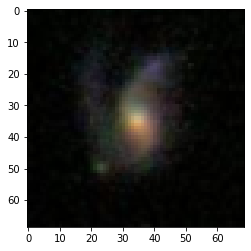

In [ ]:
plt.imshow(class_9_images[466])

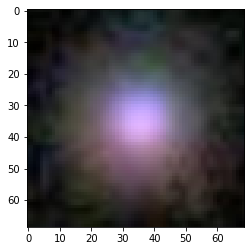

In [ ]:
plt.imshow(train_images[0])

In [ ]:
#Note you can data augment after rescaling them between [0,1] 
#Basically its our must precocessing that we need to do for images!!! Make them into numbers between 0s and 1s then augment them into dtpes of 32bit

# rescaling_ = Sequential([
#             Resizing(69, 69),  #all the images frorm the galaxy dataset arre 69x69.. but incase we want to resize to a different shape          
#             Rescaling(1./255)  #this standardizes pixels value to the [0,1] range... if wanted it to be [-1,1] do 1./127.5, offset=-1
#  ])  

In [ ]:
class_9_images[466]

array([[[0.01176471, 0.01960784, 0.00784314],
        [0.00392157, 0.01176471, 0.00392157],
        [0.        , 0.00784314, 0.        ],
        ...,
        [0.01960784, 0.01960784, 0.01176471],
        [0.01568628, 0.01568628, 0.00784314],
        [0.00784314, 0.00784314, 0.        ]],

       [[0.01568628, 0.02352941, 0.01176471],
        [0.01176471, 0.01960784, 0.00784314],
        [0.        , 0.00784314, 0.        ],
        ...,
        [0.02352941, 0.02745098, 0.01568628],
        [0.01960784, 0.02352941, 0.01568628],
        [0.01176471, 0.01960784, 0.00784314]],

       [[0.01176471, 0.01960784, 0.00784314],
        [0.01960784, 0.02745098, 0.01568628],
        [0.01176471, 0.01960784, 0.01176471],
        ...,
        [0.02745098, 0.03529412, 0.02352941],
        [0.01960784, 0.02745098, 0.01568628],
        [0.01176471, 0.01960784, 0.00784314]],

       ...,

       [[0.01568628, 0.02352941, 0.01960784],
        [0.01568628, 0.01568628, 0.01568628],
        [0.00784314, 0

# Data Augmentation!

Before Augmenting, we need to preprocess the images...

In [ ]:
IMG_SIZE = 69

resize_and_rescale = tf.keras.Sequential([
  Resizing(IMG_SIZE, IMG_SIZE),
  #Rescaling(1./255) #since we already divided by 255 above we dont have to do it again or we will geet just a black image
])

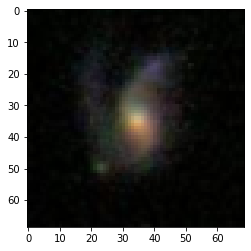

In [ ]:
result = resize_and_rescale(class_9_images[-1])
_ = plt.imshow(result)

We processed our images into tensorflow type!

In [ ]:
type(result)  # 

tensorflow.python.framework.ops.EagerTensor

In [ ]:
result

<tf.Tensor: shape=(69, 69, 3), dtype=float32, numpy=
array([[[0.01176471, 0.01960784, 0.00784314],
        [0.00392157, 0.01176471, 0.00392157],
        [0.        , 0.00784314, 0.        ],
        ...,
        [0.01960784, 0.01960784, 0.01176471],
        [0.01568628, 0.01568628, 0.00784314],
        [0.00784314, 0.00784314, 0.        ]],

       [[0.01568628, 0.02352941, 0.01176471],
        [0.01176471, 0.01960784, 0.00784314],
        [0.        , 0.00784314, 0.        ],
        ...,
        [0.02352941, 0.02745098, 0.01568628],
        [0.01960784, 0.02352941, 0.01568628],
        [0.01176471, 0.01960784, 0.00784314]],

       [[0.01176471, 0.01960784, 0.00784314],
        [0.01960784, 0.02745098, 0.01568628],
        [0.01176471, 0.01960784, 0.01176471],
        ...,
        [0.02745098, 0.03529412, 0.02352941],
        [0.01960784, 0.02745098, 0.01568628],
        [0.01176471, 0.01960784, 0.00784314]],

       ...,

       [[0.01568628, 0.02352941, 0.01960784],
        [0.0156

In [ ]:
#clone_class9 = resize_and_rescale(class_9_images.copy)
#len(class_9_images)
clone_class9 = []
for i in range(len(class_9_images)):
  clone_class9.append(resize_and_rescale(class_9_images[i]))
len(clone_class9)

467

Since we appended the converted images into a list, we need to convert that list into a numpy array! -- **actually no we dont need to. it is fine to keep it as a list for now**

In [ ]:
class_9_images[0]

array([[[0.47843137, 0.3764706 , 0.5686275 ],
        [0.48235294, 0.3764706 , 0.61960787],
        [0.49019608, 0.39607844, 0.6431373 ],
        ...,
        [0.05098039, 0.03137255, 0.04313726],
        [0.05490196, 0.03921569, 0.03921569],
        [0.03921569, 0.01568628, 0.01568628]],

       [[0.42745098, 0.31764707, 0.4862745 ],
        [0.42745098, 0.32156864, 0.52156866],
        [0.4392157 , 0.34117648, 0.5411765 ],
        ...,
        [0.03921569, 0.03137255, 0.01568628],
        [0.05098039, 0.04313726, 0.03137255],
        [0.07058824, 0.05490196, 0.05098039]],

       [[0.37254903, 0.25882354, 0.40392157],
        [0.3764706 , 0.27058825, 0.42745098],
        [0.39607844, 0.3019608 , 0.4509804 ],
        ...,
        [0.04705882, 0.02745098, 0.00392157],
        [0.05882353, 0.05490196, 0.03529412],
        [0.09411765, 0.08235294, 0.07450981]],

       ...,

       [[0.2509804 , 0.16078432, 0.12941177],
        [0.2509804 , 0.15294118, 0.12941177],
        [0.2509804 , 0

In [ ]:
inc1 = class_9_images[:2]
len(inc1)

2

In [ ]:
inc2 = class_9_images[2:4]
len(inc2)

2

In [ ]:
len((inc1 + inc2))

4

In [ ]:
type(clone_class9)

list

In [ ]:
np.asarray(clone_class9).shape

(467, 69, 69, 3)

In [ ]:
np.asarray(clone_class9)

array([[[[0.47843137, 0.3764706 , 0.5686275 ],
         [0.48235294, 0.3764706 , 0.61960787],
         [0.49019608, 0.39607844, 0.6431373 ],
         ...,
         [0.05098039, 0.03137255, 0.04313726],
         [0.05490196, 0.03921569, 0.03921569],
         [0.03921569, 0.01568628, 0.01568628]],

        [[0.42745098, 0.31764707, 0.4862745 ],
         [0.42745098, 0.32156864, 0.52156866],
         [0.4392157 , 0.34117648, 0.5411765 ],
         ...,
         [0.03921569, 0.03137255, 0.01568628],
         [0.05098039, 0.04313726, 0.03137255],
         [0.07058824, 0.05490196, 0.05098039]],

        [[0.37254903, 0.25882354, 0.40392157],
         [0.3764706 , 0.27058825, 0.42745098],
         [0.39607844, 0.3019608 , 0.4509804 ],
         ...,
         [0.04705882, 0.02745098, 0.00392157],
         [0.05882353, 0.05490196, 0.03529412],
         [0.09411765, 0.08235294, 0.07450981]],

        ...,

        [[0.2509804 , 0.16078432, 0.12941177],
         [0.2509804 , 0.15294118, 0.12941177]

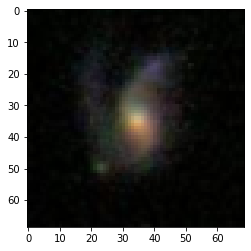

In [ ]:
plt.imshow(clone_class9[-1])

In [ ]:
image = tf.cast(tf.expand_dims((clone_class9[-1]), 0), tf.float32)

In [ ]:
image

<tf.Tensor: shape=(1, 69, 69, 3), dtype=float32, numpy=
array([[[[0.01176471, 0.01960784, 0.00784314],
         [0.00392157, 0.01176471, 0.00392157],
         [0.        , 0.00784314, 0.        ],
         ...,
         [0.01960784, 0.01960784, 0.01176471],
         [0.01568628, 0.01568628, 0.00784314],
         [0.00784314, 0.00784314, 0.        ]],

        [[0.01568628, 0.02352941, 0.01176471],
         [0.01176471, 0.01960784, 0.00784314],
         [0.        , 0.00784314, 0.        ],
         ...,
         [0.02352941, 0.02745098, 0.01568628],
         [0.01960784, 0.02352941, 0.01568628],
         [0.01176471, 0.01960784, 0.00784314]],

        [[0.01176471, 0.01960784, 0.00784314],
         [0.01960784, 0.02745098, 0.01568628],
         [0.01176471, 0.01960784, 0.01176471],
         ...,
         [0.02745098, 0.03529412, 0.02352941],
         [0.01960784, 0.02745098, 0.01568628],
         [0.01176471, 0.01960784, 0.00784314]],

        ...,

        [[0.01568628, 0.02352941, 0.

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

**Flipping**

In [ ]:
#This type of flipping happens during the preprocessing of the model!
data_augmentation = Sequential([
                                RandomFlip('horizontal_and_vertical'),
                               # RandomRotation(0.2)
                                ])

In [ ]:
#Add the image to a batch
                  # I dont have to add the rescaling method here because I already did it around my train_test split   
image = tf.cast(tf.expand_dims((class_9_images[466]), 0), tf.float32)

In [ ]:
image

<tf.Tensor: shape=(1, 69, 69, 3), dtype=float32, numpy=
array([[[[0.01176471, 0.01960784, 0.00784314],
         [0.00392157, 0.01176471, 0.00392157],
         [0.        , 0.00784314, 0.        ],
         ...,
         [0.01960784, 0.01960784, 0.01176471],
         [0.01568628, 0.01568628, 0.00784314],
         [0.00784314, 0.00784314, 0.        ]],

        [[0.01568628, 0.02352941, 0.01176471],
         [0.01176471, 0.01960784, 0.00784314],
         [0.        , 0.00784314, 0.        ],
         ...,
         [0.02352941, 0.02745098, 0.01568628],
         [0.01960784, 0.02352941, 0.01568628],
         [0.01176471, 0.01960784, 0.00784314]],

        [[0.01176471, 0.01960784, 0.00784314],
         [0.01960784, 0.02745098, 0.01568628],
         [0.01176471, 0.01960784, 0.01176471],
         ...,
         [0.02745098, 0.03529412, 0.02352941],
         [0.01960784, 0.02745098, 0.01568628],
         [0.01176471, 0.01960784, 0.00784314]],

        ...,

        [[0.01568628, 0.02352941, 0.

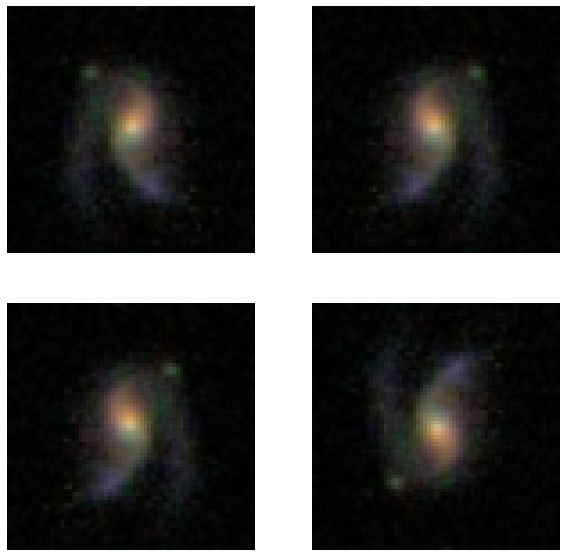

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(4):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(2, 2, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")
  #class_5_images_copy.append(augmented_image[0])

In [ ]:
type(augmented_image[0])

tensorflow.python.framework.ops.EagerTensor

In [ ]:
type(class_9_images[466])

numpy.ndarray

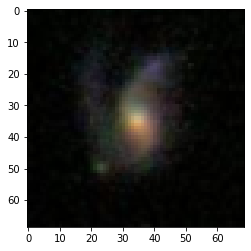

In [ ]:
plt.imshow(class_9_images[466])

In [ ]:
class_9_images[466]


array([[[0.01176471, 0.01960784, 0.00784314],
        [0.00392157, 0.01176471, 0.00392157],
        [0.        , 0.00784314, 0.        ],
        ...,
        [0.01960784, 0.01960784, 0.01176471],
        [0.01568628, 0.01568628, 0.00784314],
        [0.00784314, 0.00784314, 0.        ]],

       [[0.01568628, 0.02352941, 0.01176471],
        [0.01176471, 0.01960784, 0.00784314],
        [0.        , 0.00784314, 0.        ],
        ...,
        [0.02352941, 0.02745098, 0.01568628],
        [0.01960784, 0.02352941, 0.01568628],
        [0.01176471, 0.01960784, 0.00784314]],

       [[0.01176471, 0.01960784, 0.00784314],
        [0.01960784, 0.02745098, 0.01568628],
        [0.01176471, 0.01960784, 0.01176471],
        ...,
        [0.02745098, 0.03529412, 0.02352941],
        [0.01960784, 0.02745098, 0.01568628],
        [0.01176471, 0.01960784, 0.00784314]],

       ...,

       [[0.01568628, 0.02352941, 0.01960784],
        [0.01568628, 0.01568628, 0.01568628],
        [0.00784314, 0

In [ ]:
class_9_images[466].shape

(69, 69, 3)

In [ ]:
len(class_9_images)

467

In [ ]:
# NumPy.'img' = A single image.
x = np.fliplr(class_9_images[466])
# TensorFlow. 'x' = A placeholder for an image.
shape = [69, 69, 3]
#x = tf.flip_1(dtype = tf.float32, shape = shape)
flip_3 = tf.image.flip_left_right(x)
flip_4 = tf.image.random_flip_up_down(x)
flip_5 = tf.image.random_flip_left_right(x)

In [ ]:
type(class_9_images[466])

numpy.ndarray

In [ ]:
list(class_9_images[466])

In [ ]:
#**********************************************
np.array_equal(class_9_images[466], class_9_images[466])  #how we can check to see we dont generate duplicates!!!
          #True if they are equal.. False if the are not!

True

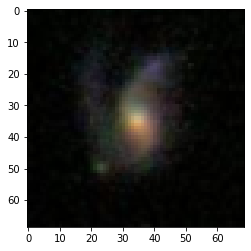

In [ ]:
plt.imshow(flip_3)  #these 2 images flip 2 and 3 are not the same! checked with '=='

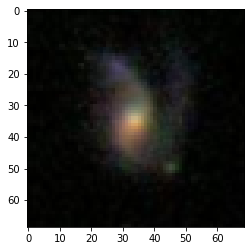

In [ ]:
flipped = tf.image.flip_left_right(class_9_images[466])
plt.imshow(flipped)

In [ ]:
flipped

**Greyscale an Image**

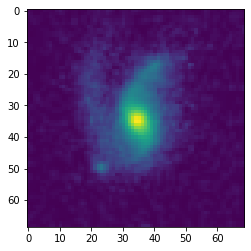

In [ ]:
grayscaled = tf.image.rgb_to_grayscale(class_9_images[466])
plt.imshow(tf.squeeze(grayscaled))

In [ ]:
tf.squeeze(grayscaled)

<tf.Tensor: shape=(69, 69), dtype=float32, numpy=
array([[0.01592039, 0.0085251 , 0.00460392, ..., 0.01871177, 0.01479059,
        0.00694824],
       [0.01984157, 0.01592039, 0.00460392, ..., 0.0249349 , 0.02146079,
        0.01592039],
       [0.01592039, 0.02376275, 0.01636745, ..., 0.0316051 , 0.02376275,
        0.01592039],
       ...,
       [0.02073569, 0.01568471, 0.00784235, ..., 0.        , 0.        ,
        0.        ],
       [0.01681451, 0.00784235, 0.00392118, ..., 0.00694824, 0.00694824,
        0.00694824],
       [0.00505098, 0.01176353, 0.01176353, ..., 0.00347412, 0.00739529,
        0.00739529]], dtype=float32)>

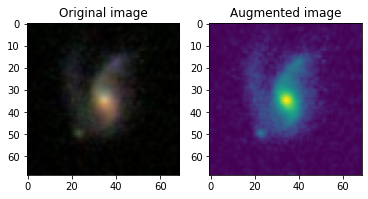

In [ ]:
visualize(class_9_images[466], tf.squeeze(grayscaled))


**Saturation**

<Figure size 720x720 with 0 Axes>

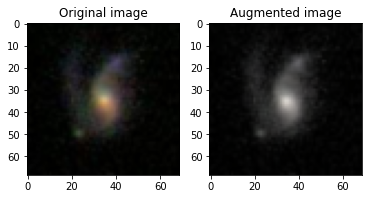

In [ ]:
# saturation_factor --	float. -- Factor to multiply the saturation by.
saturated = tf.image.adjust_saturation(class_9_images[466], random.uniform(0,1)) # saturation rate be numbers between 0 and 1
plt.figure(figsize=(10,10))
visualize( class_9_images[466], saturated )

<Figure size 720x720 with 0 Axes>

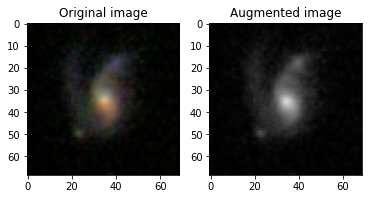

In [ ]:
saturated2 = tf.image.adjust_saturation(class_9_images[466], 0)
plt.figure(figsize=(10,10))
visualize( class_9_images[466], saturated2 )

In [ ]:
np.array_equal(saturated, saturated2)

False

In [ ]:
np.array_equal(saturated, class_9_images[466])

False

**Change Image Brightness**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


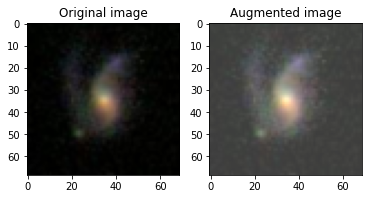

In [ ]:
#        delta can be in range of (-1,1)       delta A scalar. Amount to add to the pixel values.
bright = tf.image.adjust_brightness(class_9_images[466], random.uniform(-0.5,0.5))# .. so max neg range will be to -0.5.. pos 0.5
visualize(class_9_images[466], bright)

In [ ]:
random.uniform(-1,1)

-0.5102162923930476

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


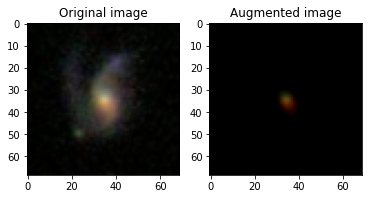

In [ ]:
#Or
bright = tf.image.stateless_random_brightness(
    class_9_images[466],
    max_delta =  1,   #float, must be non-negative. between 0 and 1 but not equal to 0 or 1
    seed = (123412,42)         #A shape [2] Tensor, the seed to the random number generator. Must have dtype int32 or int64.
                                          # No float for the seeds!
)
visualize(class_9_images[466], bright)

**Cropping the image**

Note: We will need to do preprocessing of resizing, after cropping, to 69x69!

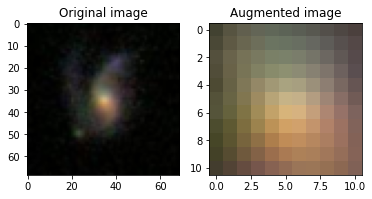

In [ ]:
#central_fraction	float (0, 1], fraction of size to crop
cropped = tf.image.central_crop(class_9_images[466], random.uniform(0,1))  
visualize(class_9_images[466], cropped)

In [ ]:
cropped.shape

TensorShape([11, 11, 3])

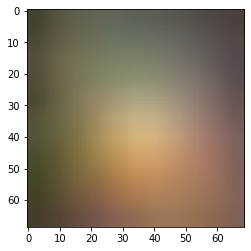

In [ ]:
plt.imshow(tf.image.resize(cropped, [69, 69]))

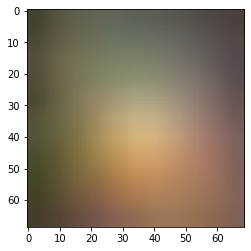

In [ ]:
result = resize_and_rescale(cropped)
_ = plt.imshow(result)

In [ ]:
result.shape

TensorShape([69, 69, 3])

**Rotate an Image**

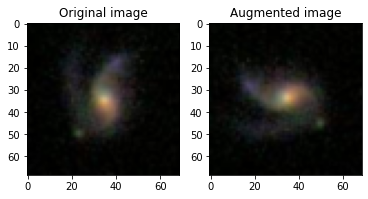

In [ ]:
              # has an argument k: 	A scalar integer tensor. The number of times the image(s) are rotated by 90 degrees.
              #default set to 1
rotated = tf.image.rot90(class_9_images[466])
visualize(class_9_images[466], rotated)

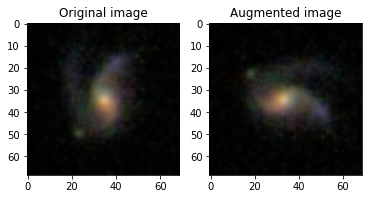

In [ ]:
rotated = tf.image.rot90(class_9_images[466], k = -1)
visualize(class_9_images[466], rotated)

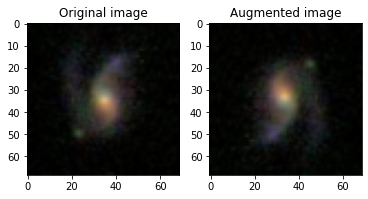

In [ ]:
rotated = tf.image.rot90(class_9_images[466], 2)
visualize(class_9_images[466], rotated)

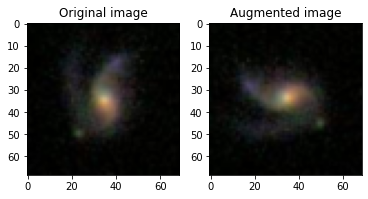

In [ ]:
rotated = tf.image.rot90(class_9_images[466], random.randint(1,4))
visualize(class_9_images[466], rotated)

In [ ]:
np.array_equal(class_9_images[466], rotated) 

False

In [ ]:
rotated

**Lets starting creating augmented images to balance out our classes!**

In [ ]:
pd.DataFrame(train_labels_unencoded, columns=['class']).value_counts()

class
1        6297
2        5663
0        3115
4        1381
7        1009
8         815
6         530
9         467
3         314
5          15
dtype: int64

In [ ]:
#macro between class 0 and 5...  calc my f1 score for 3 and and 5.. avg them together.. which means im weighing my f f1 score more then my 3
#micro im taking 320 and 14.. calc number of times i got right nad wrong and get f1 score from it
#                                                             



We want create images for classes that are not 1 or 2. We want those classes to have near 4k images. We will create a seprate list of augmented images for each class. Then we will combine the augmented class images into the original dataset that it was augmented from and also create the vector the match the length of the combined list. After doing it for each of the classes, we will combine them altogether to be represented as the training set!  

In [ ]:
#may want to perform augmentation on class 1 and 2.. but give it very less data

In [ ]:
#Do a an experiment with how much images you have for example:
# all the classes are fixed except class 5.. you will want to generate images until you have 50
# THEN YOU train on it for your neural networks and see how it performs .. then you can do it again with a new amount of class 5 images!

In [ ]:
def augmentation(image_dataset):
  image_goal = 4000  #adjust this number depending the amount of images you want to total (augmented_images + regular_dataset)
  aug_images = []
  image_dataset = image_dataset
        #while the lenght of our (original dataset + aug_images dataset) is less than to our image goal
        #keep producing images until we hit that goal!
  while ((len(image_dataset) + len(aug_images)) < image_goal):
    #choose a random image to augment on:
    image = random.choice(image_dataset)

    #flip
    augmented_image = tf.image.flip_left_right(image)

    #saturate
    augmented_image = tf.image.adjust_saturation(augmented_image, random.uniform(0,1))

    #brightness
    augmented_image = tf.image.adjust_brightness(augmented_image, random.uniform(-0.5,0.5))

    #crop  and resize back to 69x69
    augmented_image = tf.image.central_crop(augmented_image, random.uniform(0,1))
    augmented_image = tf.image.resize(augmented_image, [69, 69])

    #rotate  ... since it is a square shape we dont have to worry about reshaping!
    augmented_image = tf.image.rot90(augmented_image, random.randint(1,4))

   #I want to verify i didnt somehow create a duplicate augmented image
    flag = False
    if (len(aug_images) > 0):
      for pics in aug_images:
        if (np.array_equal(pics, augmented_image) == True):
          #The moment we find a copy we will just exit the loop and not append it into our augmented dataset
          flag = True
          break
    #if flag is still false after the above... append into our augmented dataset
    if flag == False:
      aug_images.append(augmented_image)


  return aug_images

Now call our function onto our separted class images list for
class_0,3,4,5,6,7,8,9  

In [ ]:
#Class 5 :  ============================================================================================
class_5_aug = augmentation(class_5_images)

In [ ]:
len(class_5_aug)

3985

In [ ]:
len(class_5_aug + class_5_images)

4000

In [ ]:
class_5_train_set = class_5_aug + class_5_images
len(class_5_train_set)

4000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


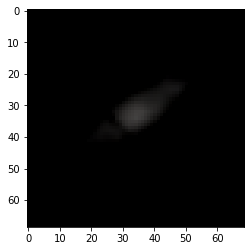

In [ ]:
plt.imshow(random.choice(class_5_train_set))

In [38]:
#Save it so I dont have to run it again and I just have to load it!
#np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class5_train.npy', class_5_train_set,allow_pickle=True)
class_5_ts = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class5_train.npy', allow_pickle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


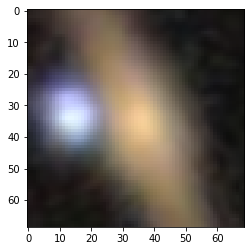

In [39]:
plt.imshow(class_5_ts[0])

In [33]:
class_5_ts.shape

(4000, 69, 69, 3)

In [ ]:
#Class 0 :  ============================================================================================
class_0_aug = augmentation(class_0_images)
class_0_train_set = class_0_aug + class_0_images

#then save it
np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class0_train.npy', class_0_train_set,allow_pickle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4000


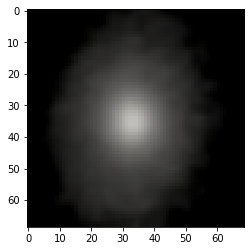

In [40]:
#load our Class 0
class_0_ts = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class0_train.npy', allow_pickle=True)
plt.imshow(class_0_ts[0])
print(len(class_0_ts))

In [ ]:
#Class 3:============================================================================================
class_3_aug = augmentation(class_3_images)
class_3_train_set = class_3_aug + class_3_images

#then save it
np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class3_train.npy', class_3_train_set,allow_pickle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4000


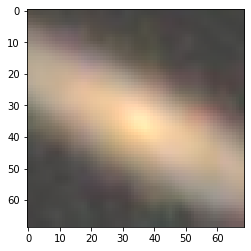

In [41]:
#load our Class 3
class_3_ts = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class3_train.npy', allow_pickle=True)
plt.imshow(class_3_ts[0])
print(len(class_3_ts))

In [ ]:
#Class 4:============================================================================================
class_4_aug = augmentation(class_4_images)
class_4_train_set = class_4_aug + class_4_images

#then save it
np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class4_train.npy', class_4_train_set,allow_pickle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4000


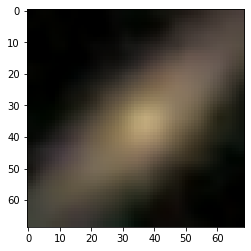

In [42]:
#load our Class 4
class_4_ts = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class4_train.npy', allow_pickle=True)
plt.imshow(class_4_ts[0])
print(len(class_4_ts))

In [ ]:
#Class 6:============================================================================================
class_6_aug = augmentation(class_6_images)
class_6_train_set = class_6_aug + class_6_images

#then save it
np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class6_train.npy', class_6_train_set,allow_pickle=True)

4000


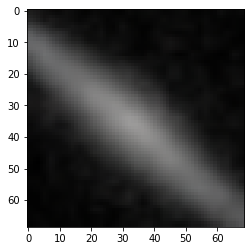

In [43]:
#load our Class 6
class_6_ts = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class6_train.npy', allow_pickle=True)
plt.imshow(class_6_ts[0])
print(len(class_6_ts))

In [ ]:
#Class 7:============================================================================================
class_7_aug = augmentation(class_7_images)
class_7_train_set = class_7_aug + class_7_images

#then save it
np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class7_train.npy', class_7_train_set,allow_pickle=True)

4000


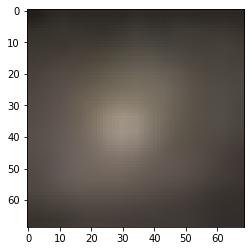

In [44]:
#load our Class 7
class_7_ts = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class7_train.npy', allow_pickle=True)
plt.imshow(class_7_ts[0])
print(len(class_7_ts))

In [ ]:
#Class 8:============================================================================================
class_8_aug = augmentation(class_8_images)
class_8_train_set = class_8_aug + class_8_images

#then save it
np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class8_train.npy', class_8_train_set,allow_pickle=True)

4000


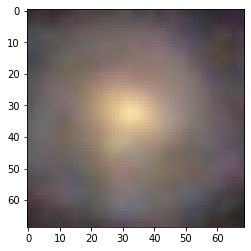

In [45]:
#load our Class 8
class_8_ts = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class8_train.npy', allow_pickle=True)
plt.imshow(class_8_ts[0])
print(len(class_8_ts))

In [ ]:
#Class 9:============================================================================================
class_9_aug = augmentation(class_9_images)
class_9_train_set = class_9_aug + class_9_images

#then save it
np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class9_train.npy', class_9_train_set,allow_pickle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4000


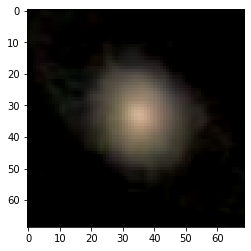

In [46]:
#load our Class 9
class_9_ts = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class9_train.npy', allow_pickle=True)
plt.imshow(class_9_ts[0])
print(len(class_9_ts))

In [ ]:
#save class_1_images and class_2_images also--------------------------------------------------------------------------
len(class_1_images)

6297

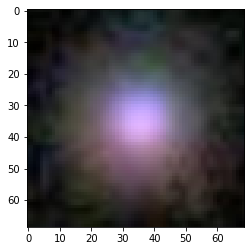

In [ ]:
plt.imshow(class_1_images[0])

6297


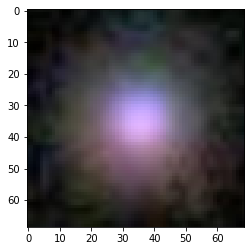

In [47]:
#save class1_train !
#np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class1_train.npy', class_1_images, allow_pickle=True)

#load our Class 1
class_1_images = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class1_train.npy', allow_pickle=True)
plt.imshow(class_1_images[0])
print(len(class_1_images))


In [ ]:
len(class_2_images)

5663

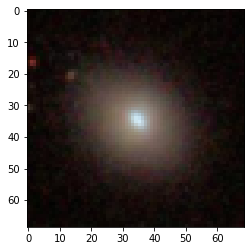

In [ ]:
plt.imshow(class_2_images[0])

5663


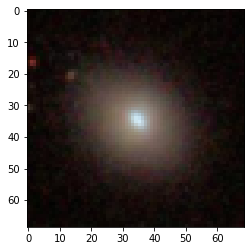

In [48]:
#save class2_train !
#np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class2_train.npy', class_2_images, allow_pickle=True)

#load our Class 1
class_2_images = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/class2_train.npy', allow_pickle=True)
plt.imshow(class_2_images[0])
print(len(class_2_images))

In [51]:
class_1_images.shape

(6297, 69, 69, 3)

In [50]:
class_2_images.shape

(5663, 69, 69, 3)

In [54]:
####--- i can index slice the arrray to make it a different target shape for my class_1 and class_2----------===========================================================================================
#i will slice it where I will have them both be 4k images each to match the classes that got augmented to have 4k images.. this will be
# a different model where i want to compare it to the trained images of 4k augmented classes + the static class 1 and 2
class_1_images_slice = class_1_images[:4000]
class_2_images_slice = class_2_images[:4000]

class_1_images_slice.shape, class_2_images_slice.shape

((4000, 69, 69, 3), (4000, 69, 69, 3))

In [56]:
#Combine all our list  togetherr and we can create a balanced dataset!:
train_images_v3 = [class_0_ts, class_1_images_slice, class_2_images_slice, class_3_ts, class_4_ts, class_5_ts, class_6_ts, class_7_ts, class_8_ts, class_9_ts]
len(train_images_v3) #right now its a list of list holding the images of each class

10

In [65]:
#np.array(list(itertools.chain.from_iterable(train_images_v3))).shape
train_images_v3 = np.array(list(itertools.chain.from_iterable(train_images_v3)))  #combine all the list together and then convert to numpy array
train_images_v3.shape

(40000, 69, 69, 3)

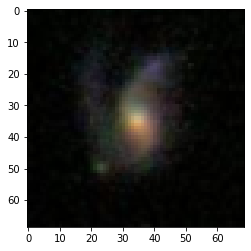

In [66]:
plt.imshow(train_images_v3[-1])

In [67]:
#then save it
np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/BalancedTrainImages_and_augImages.npy', train_images_v3,allow_pickle=True)

In [33]:
#load it so we dont have re run alot of the code again: ***************************
train_images_v3 = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/BalancedTrainImages_and_augImages.npy', allow_pickle=True)
train_images_v3.shape

(40000, 69, 69, 3)

In [81]:
#now for the labels!!!!
train_labels_v3 = [ len(class_0_ts) *[0], len(class_1_images_slice) * [1], len(class_2_images_slice)*[2], len(class_3_ts) * [3], len(class_4_ts)*[4], len(class_5_ts) * [5], len(class_6_ts) * [6], len(class_7_ts) * [7], len(class_8_ts) * [8], len(class_9_ts) *[9] ]

In [82]:
len(train_labels_v3)  #its a list of lists atm

10

In [83]:
train_labels_v3 = list(itertools.chain.from_iterable(train_labels_v3))
len(train_labels_v3), type(train_labels_v3) # now its a list of the target variables!

(40000, list)

In [86]:
train_labels_v3 = np.array(train_labels_v3)
train_labels_v3.shape, type(train_labels_v3)



((40000,), numpy.ndarray)

In [87]:
#sAVE THE train_labels_v3 --------------------------------------------------------------
np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/LABELS_BalanceTrainImages_and_augImages.npy', train_labels_v3, allow_pickle=True)

In [34]:
#load our labels v3---------------------------------- ***************************************
train_labels_v3 = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/LABELS_BalanceTrainImages_and_augImages.npy', allow_pickle=True)
train_labels_v3.shape

(40000,)

In [35]:
train_labels_v3_encoded = utils.to_categorical(train_labels_v3, 10)
train_labels_v3_encoded[-1], train_labels_v3.shape

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32), (40000,))

In [20]:
#shuffled:
c = list(zip(train_images_v3, train_labels_v3_encoded))

random.shuffle(c)

#its a tuple after we unzip it.. need to make it back to a numpy arrray
train_images_v3, train_labels_v3_encoded = zip(*c)

#CONVERT BACK TO NUMPY AFTERR THE SHUFFLING!
train_images_v3 = np.array(train_images_v3)
train_labels_v3_encoded = np.array(train_labels_v3_encoded)

train_labels_v3_encoded.shape, train_images_v3.shape

((40000, 10), (40000, 69, 69, 3))

In [36]:
#train test split the data and combine it after   -- shuffling method also
X_train, X_test, y_train, y_test = train_test_split(train_images_v3, train_labels_v3_encoded, stratify= train_labels_v3_encoded, random_state=42 )
X_trainv2 = np.concatenate((X_train, X_test))
y_trainv2 = np.concatenate((y_train, y_test))
X_trainv2.shape, y_trainv2.shape


((40000, 69, 69, 3), (40000, 10))

In [37]:
# #then save it#===================================================================================================================================================================
#np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/ShuffledBalancedTrainImages_and_augImages.npy', X_trainv2, allow_pickle=True)
# np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/ShuffledBalancedTrain_Labels.npy', y_trainv2, allow_pickle=True)

# #load it so we dont have re run alot of the code again: ++++++++++++++++++++++++++++++++++++++++++++====================================
train_images_v3_shuffled = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/ShuffledBalancedTrainImages_and_augImages.npy', allow_pickle=True)
train_labels_v3_encoded_shuffled = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/ShuffledBalancedTrain_Labels.npy', allow_pickle=True)

train_images_v3_shuffled.shape, train_labels_v3_encoded_shuffled.shape

((40000, 69, 69, 3), (40000, 10))

In [ ]:
######-------------
######-------------------------------------------------------------------------------------------
######-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Recreate the labels column to match the length of each of the class images dataset. Combine our list together

In [ ]:
train_images_v2 = [class_0_ts, class_1_images, class_2_images, class_3_ts, class_4_ts, class_5_ts, class_6_ts, class_7_ts, class_8_ts, class_9_ts]

In [ ]:
#then save it
#np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/originalTrainImages_and_augImages.npy', train_images_v2,allow_pickle=True)

In [ ]:
#load it so we dont have re run alot of the code again: ++++++++++++++++++++++++++++++++++++++++++++====================================
#train_images_v2 = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/originalTrainImages_and_augImages.npy', allow_pickle=True)

In [ ]:
len(train_images_v2)

10

In [ ]:
for x in train_images_v2:
  print(len(x))

4000
6297
5663
4000
4000
4000
4000
4000
4000
4000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


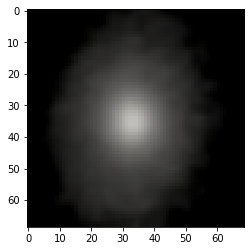

In [ ]:
plt.imshow(train_images_v2[0][0])

In [ ]:
np.array_equal(train_images_v2[0][0],class_0_ts[0])

True

In [ ]:
classify_0 = [0] * len(class_0_ts)

In [ ]:
len(classify_0)

4000

In [ ]:
train_labels_v2 = [ len(class_0_ts) *[0], len(class_1_images) * [1], len(class_2_images)*[2], len(class_3_ts) * [3], len(class_4_ts)*[4], len(class_5_ts) * [5], len(class_6_ts) * [6], len(class_7_ts) * [7], len(class_8_ts) * [8], len(class_9_ts) *[9] ]

In [ ]:
len(train_labels_v2)

10

In [ ]:
for x in train_labels_v2:
  print (x[0], len(x))

0 4000
1 6297
2 5663
3 4000
4 4000
5 4000
6 4000
7 4000
8 4000
9 4000


In [ ]:
import itertools
len(list(itertools.chain.from_iterable(train_images_v2)))

43960

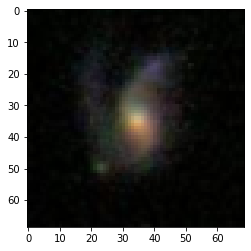

In [ ]:
plt.imshow(list(itertools.chain.from_iterable(train_images_v2))[-1] )

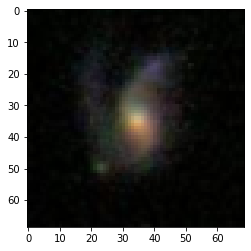

In [ ]:
plt.imshow(class_9_ts[-1])     #they are in order after connecting them together!! ^

In [ ]:
train_images_v2 = list(itertools.chain.from_iterable(train_images_v2))

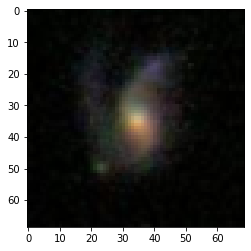

In [ ]:
plt.imshow(train_images_v2[-1])

In [18]:
#then save it#===================================================================================================================================================================
#after we combine all our new dataset with augmented images
#np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/originalTrainImages_and_augImages.npy', train_images_v2,allow_pickle=True)

#load it so we dont have re run alot of the code again: ++++++++++++++++++++++++++++++++++++++++++++====================================
train_images_v2 = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/originalTrainImages_and_augImages.npy', allow_pickle=True)

In [19]:
type(train_images_v2)

numpy.ndarray

In [20]:
train_images_v2.shape

(43960, 69, 69, 3)

In [ ]:
train_labels_v2 = list(itertools.chain.from_iterable(train_labels_v2))

In [ ]:
type(train_images_v2)

numpy.ndarray

In [ ]:
train_images_v2.shape

In [ ]:
#==============================================================================================================================================================

In [ ]:
#sAVE THE train_labels_v2 ==============================================================================================================================================================
np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/LABELS_originalTrainImages_and_augImages.npy', train_labels_v2, allow_pickle=True)

In [15]:
#load our labels ----------------------------------
train_labels_v2 = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/LABELS_originalTrainImages_and_augImages.npy', allow_pickle=True)
train_labels_v2_encoded = utils.to_categorical(train_labels_v2, 10)

In [16]:
type(train_labels_v2)

numpy.ndarray

In [17]:
len(train_labels_v2)

43960

In [ ]:
train_labels_v2[-1]

9

In [24]:
train_labels_v2_encoded[-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
train_images_v2[0].shape

(69, 69, 3)

In [ ]:
train_images_v2.shape

(43960, 69, 69, 3)

In [ ]:
test_images.shape

(2179, 69, 69, 3)

In [25]:
train_labels_v2_encoded.shape

(43960, 10)

In [ ]:
test_labels.shape

(2179, 10)

In [ ]:
#shuffled:
c = list(zip(train_images_v2, train_labels_v2_encoded))

random.shuffle(c)

#its a tuple after we unzip it.. need to make it back to a numpy arrray
train_images_v2, train_labels_v2_encoded = zip(*c)



In [27]:
#train test split the data and combine it after   -- shuffling method also
X_train, X_test, y_train, y_test = train_test_split(train_images_v2, train_labels_v2_encoded, stratify= train_labels_v2_encoded, random_state=42 )

In [32]:
X_trainv2 = np.concatenate((X_train, X_test))
y_trainv2 = np.concatenate((y_train, y_test))
X_trainv2.shape, y_trainv2.shape

((43960, 69, 69, 3), (43960, 10))

In [12]:
#then save it#===================================================================================================================================================================
# np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/ShuffledOriginalTrainImages_and_augImages.npy', X_trainv2, allow_pickle=True)
# np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/ShuffledOriginalTrain_Labels.npy', y_trainv2, allow_pickle=True)

#load it so we dont have re run alot of the code again: ++++++++++++++++++++++++++++++++++++++++++++====================================
train_images_v2_shuffled = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/ShuffledOriginalTrainImages_and_augImages.npy', allow_pickle=True)
train_labels_v2_encoded_shuffled = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/ShuffledOriginalTrain_Labels.npy', allow_pickle=True)

train_images_v2_shuffled.shape, train_labels_v2_encoded_shuffled.shape

((43960, 69, 69, 3), (43960, 10))

(10990, 69, 69, 3)

In [ ]:
#CONVERT BACK TO NUMPY AFTERR THE SHUFFLING!
train_images_v2 = np.array(train_images_v2)
train_labels_v2_encoded = np.array(train_labels_v2_encoded)

In [ ]:
train_labels_v2_encoded.shape, train_images_v2.shape

((43960, 10), (43960, 69, 69, 3))

In [ ]:
train_labels_v2_encoded

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Now my training set is train_images_v2 which has more images for classes that that did not have a lot of images to work with before.  We also have our new training target which is train_labels_v2.

In [ ]:
#All the images are 43938
# i = 1
# for image in train_images_v2:
#   if image.shape == (69,69,3):
#     print(f" {i}  Trrrue")
#   i = i + 1

In [ ]:
len(test_images), len(test_labels)

(2179, 2179)

In [ ]:
len(train_images_v2), len(train_labels_v2_encoded)

(43960, 43960)

In [ ]:
#train_images_v2.shape  #i need to make it into numpy array shape
#np.asarray(train_images_v2)

In [22]:
def plot_hist(hist, metric = "loss"):
    """ plot the results from neural net training 
    
    Args:
        hist (TF history object): The history of the training
        metric (string): The name of the metric to plot (name should be the same as key in hist.history)
    
    Returns: 
        None
    """
    
    plt.figure(figsize=(12, 8))

    plt.plot(hist.history[metric], label=f'Train {metric.capitalize()}')
    plt.plot(hist.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')

    plt.title(f'Training & Testing {metric.capitalize()} by Epoch', fontsize=25)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel(metric.capitalize(), fontsize=18)

    plt.legend(fontsize=18);

**Lets test our CNN!**

In [16]:
#SHUFFLED FOR TRAINED_IMAGESV2 less imbalance datasaet
#Instantiate our CNN model
cnn_model = Sequential()

##Add a convolutional layer
cnn_model.add(Conv2D(filters = 16,  #number of filters
                     kernel_size = (3,3),#height/width of filters
                     activation = 'relu', #activation ftn
                     input_shape = train_images[0].shape))  #shape of input (one image))

#Add a MaxPooling2D layer
cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling

#Add another convolutional layer
cnn_model.add(Conv2D(filters = 32,  #number of filters
                     kernel_size = (3,3),#height/width of filters
                     activation = 'relu', #activation ftn
                     input_shape = train_images[0].shape)) #shape of input (one image))

#Add another pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling


#remember to flatten to go from the matrix (box) to the vertical line of nodes!
cnn_model.add(Flatten())

# Add a densely-connected layer with 128 neurons.
cnn_model.add(Dense(128, activation='relu'))

# Add a final layer with 10 neurons.
cnn_model.add(Dense(10, activation='softmax'))


cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 67, 67, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 33, 33, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 128)              

In [18]:

#compile the model
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

#FIT ON TRAINING DATA
cnn_hist = cnn_model.fit(train_images_v2_shuffled, train_labels_v2_encoded_shuffled,
                         batch_size=256, epochs = 100,
                         validation_data=(test_images, test_labels),
                         callbacks=EarlyStopping(patience=10))

Epoch 1/100
172/172 [==============================] - 15s 23ms/step - loss: 1.7550 - accuracy: 0.3138 - val_loss: 1.2156 - val_accuracy: 0.5034
Epoch 2/100
172/172 [==============================] - 4s 20ms/step - loss: 1.4532 - accuracy: 0.4277 - val_loss: 1.0727 - val_accuracy: 0.5457
Epoch 3/100
172/172 [==============================] - 3s 20ms/step - loss: 1.2749 - accuracy: 0.5057 - val_loss: 0.9209 - val_accuracy: 0.6751
Epoch 4/100
172/172 [==============================] - 3s 20ms/step - loss: 1.1413 - accuracy: 0.5616 - val_loss: 0.8413 - val_accuracy: 0.7058
Epoch 5/100
172/172 [==============================] - 3s 20ms/step - loss: 1.0502 - accuracy: 0.6008 - val_loss: 0.7904 - val_accuracy: 0.6989
Epoch 6/100
172/172 [==============================] - 3s 20ms/step - loss: 0.9999 - accuracy: 0.6168 - val_loss: 0.7635 - val_accuracy: 0.7201
Epoch 7/100
172/172 [==============================] - 3s 20ms/step - loss: 0.9374 - accuracy: 0.6420 - val_loss: 0.7129 - val_accuracy

In [ ]:
# dont use this method to save models!!
#cnn_model.save("/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/cnn_aug.h5")
# reload_base_cnn = load_model("/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/cnn_aug.h5")
# reload_base_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 67, 67, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 33, 33, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 128)               9

In [ ]:
#USE JOBLIN TO SAVE MY MODELS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!-----------------------
#save using joblib
joblib.dump(cnn_hist, "/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/cnn_aug_jl.h5" )

load_cnn = joblib.load("/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/cnn_aug_jl.h5")

INFO:tensorflow:Assets written to: ram://991aecee-a5b8-4f49-b8b7-3716d70393d2/assets


In [ ]:
load_cnn.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

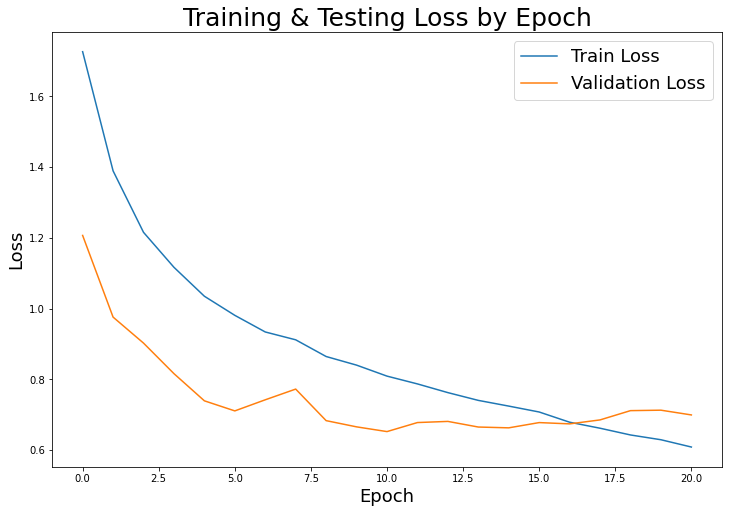

In [ ]:
plot_hist(cnn_hist, 'loss')

In [ ]:
# less data in the validation dataset.. so less opprtunity to be wrong. Also calculation

#training loss is the average......val loss is after the epoch. look at how they do in keras

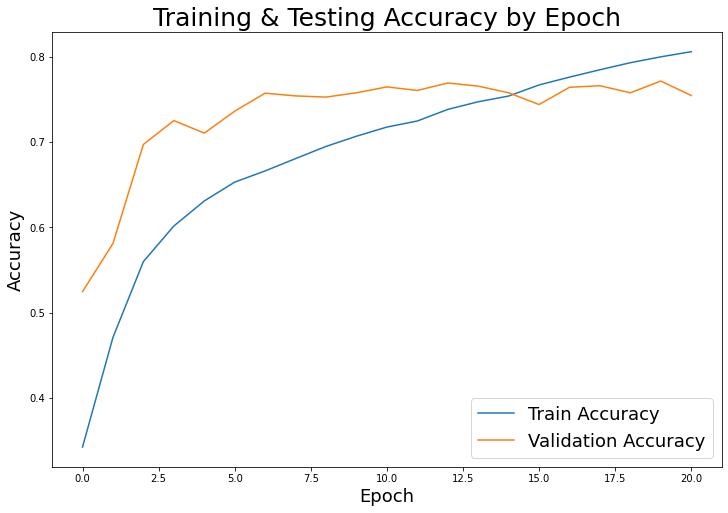

In [ ]:
plot_hist(cnn_hist, "accuracy")

In [ ]:
# you see at some point the training site isnt generalizing anymore to the testing set to make it better

In [ ]:
test_pred = load_cnn.model.predict(test_images)

In [ ]:
y_pred = np.argmax(test_pred, axis = 1)
y_pred[:5]

array([0, 0, 2, 1, 1])

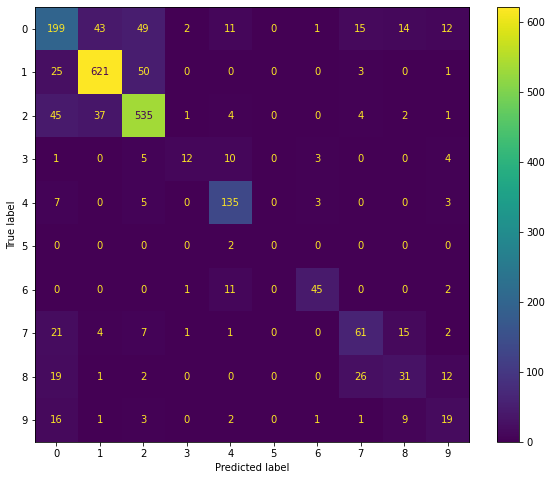

In [ ]:
# Display results in a confusion matrix (older method for sklearn < 1.0) - multiclass classification - 0 to 9 classes
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score
fig,ax = plt.subplots(figsize = (10,8))
ConfusionMatrixDisplay.from_predictions(test_labels.argmax(axis=1), y_pred, ax=ax);
# 1's show where predictions failed, diagonal is correct. 0's no error.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
print('Accuracy Score : ' + str(accuracy_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1))))

Accuracy Score : 0.7608994951812759


In [ ]:
print("F1 score of each class: ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = None) )
print("F1_score (micro): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'micro') ) #micro calculates positive and negative values globally:
                                                                                                                      #harmonic mean f1 score calc f1 score equally
print("F1_score (macro): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'macro') ) #macro, take the average of each class’s F-1 score:
print("F1_score (weighted): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'weighted') )
#The class F-1 scores are averaged by using the number of instances in a class as weights: its weighted by hte occurances
#https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#:~:text=The%20weighted%2Daveraged%20F1%20score,the%20class%20in%20the%20dataset

F1 score of each class:  [0.58615611 0.88272921 0.83268482 0.46153846 0.82066869 0.
 0.80357143 0.54954955 0.38271605 0.35185185]
F1_score (micro):  0.7608994951812759
F1_score (macro):  0.5671466181822578
F1_score (weighted):  0.7564383176512973


In [ ]:
#When it is unshuffled:==========================================================
#Instantiate our CNN model
cnn_model = Sequential()

##Add a convolutional layer
cnn_model.add(Conv2D(filters = 16,  #number of filters
                     kernel_size = (3,3),#height/width of filters
                     activation = 'relu', #activation ftn
                     input_shape = train_images_v2[0].shape))  #shape of input (one image))

#Add a MaxPooling2D layer
cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling

#Add another convolutional layer
cnn_model.add(Conv2D(filters = 32,  #number of filters
                     kernel_size = (3,3),#height/width of filters
                     activation = 'relu', #activation ftn
                     input_shape = train_images_v2[0].shape)) #shape of input (one image))

#Add another pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling


#remember to flatten to go from the matrix (box) to the vertical line of nodes!
cnn_model.add(Flatten())

# Add a densely-connected layer with 128 neurons.
cnn_model.add(Dense(128, activation='relu'))

# Add a final layer with 10 neurons.
cnn_model.add(Dense(10, activation='softmax'))


cnn_model.summary()


In [26]:
#compile the model
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

#FIT ON TRAINING DATA
cnn_hist = cnn_model.fit(train_images_v2, train_labels_v2_encoded,
                         batch_size=256, epochs = 100,
                         validation_data=(test_images, test_labels),
                         callbacks=EarlyStopping(patience=10))

Epoch 1/100
172/172 [==============================] - 4s 23ms/step - loss: 1.7408 - accuracy: 0.3182 - val_loss: 1.2146 - val_accuracy: 0.5071
Epoch 2/100
172/172 [==============================] - 3s 19ms/step - loss: 1.4414 - accuracy: 0.4331 - val_loss: 1.0082 - val_accuracy: 0.6104
Epoch 3/100
172/172 [==============================] - 3s 20ms/step - loss: 1.2403 - accuracy: 0.5216 - val_loss: 0.9059 - val_accuracy: 0.6728
Epoch 4/100
172/172 [==============================] - 3s 20ms/step - loss: 1.1298 - accuracy: 0.5654 - val_loss: 0.7837 - val_accuracy: 0.7302
Epoch 5/100
172/172 [==============================] - 3s 20ms/step - loss: 1.0501 - accuracy: 0.5997 - val_loss: 0.6846 - val_accuracy: 0.7591
Epoch 6/100
172/172 [==============================] - 3s 20ms/step - loss: 0.9934 - accuracy: 0.6218 - val_loss: 0.6701 - val_accuracy: 0.7453
Epoch 7/100
172/172 [==============================] - 3s 20ms/step - loss: 0.9451 - accuracy: 0.6388 - val_loss: 0.6488 - val_accuracy:

**Balanced Training set  (Cut down the amount of Class 1 and 2 dataset to 4k)**

In [ ]:
#unshuffled training data!

In [93]:
#Instantiate our CNN model
cnn_model = Sequential()

##Add a convolutional layer
cnn_model.add(Conv2D(filters = 16,  #number of filters
                     kernel_size = (3,3),#height/width of filters
                     activation = 'relu', #activation ftn
                     input_shape = train_images_v3[0].shape))  #shape of input (one image))

#Add a MaxPooling2D layer
cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling

#Add another convolutional layer
cnn_model.add(Conv2D(filters = 32,  #number of filters
                     kernel_size = (3,3),#height/width of filters
                     activation = 'relu', #activation ftn
                     input_shape = train_images_v3[0].shape)) #shape of input (one image))

#Add another pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling


#remember to flatten to go from the matrix (box) to the vertical line of nodes!
cnn_model.add(Flatten())

# Add a densely-connected layer with 128 neurons.
cnn_model.add(Dense(128, activation='relu'))

# Add a final layer with 10 neurons.
cnn_model.add(Dense(10, activation='softmax'))


cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 67, 67, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 33, 33, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 128)               9

In [94]:
#compile the model
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

#FIT ON TRAINING DATA
cnn_hist = cnn_model.fit(train_images_v3, train_labels_v3_encoded,
                         batch_size=256, epochs = 100,
                         validation_data=(test_images, test_labels),
                         callbacks=EarlyStopping(patience=10))

Epoch 1/100
157/157 [==============================] - 16s 24ms/step - loss: 1.8565 - accuracy: 0.2776 - val_loss: 1.3364 - val_accuracy: 0.4952
Epoch 2/100
157/157 [==============================] - 3s 21ms/step - loss: 1.5173 - accuracy: 0.4080 - val_loss: 1.0534 - val_accuracy: 0.6085
Epoch 3/100
157/157 [==============================] - 3s 22ms/step - loss: 1.3319 - accuracy: 0.4798 - val_loss: 0.9092 - val_accuracy: 0.6411
Epoch 4/100
157/157 [==============================] - 4s 23ms/step - loss: 1.2223 - accuracy: 0.5246 - val_loss: 0.9377 - val_accuracy: 0.6329
Epoch 5/100
157/157 [==============================] - 3s 21ms/step - loss: 1.1442 - accuracy: 0.5544 - val_loss: 0.7977 - val_accuracy: 0.7306
Epoch 6/100
157/157 [==============================] - 3s 21ms/step - loss: 1.0880 - accuracy: 0.5745 - val_loss: 0.7705 - val_accuracy: 0.7256
Epoch 7/100
157/157 [==============================] - 3s 22ms/step - loss: 1.0342 - accuracy: 0.5978 - val_loss: 0.6798 - val_accuracy

In [99]:
#USE JOBLIN TO SAVE MY MODELS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!-----------------------
#save using joblib
joblib.dump(cnn_hist, "/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/cnn_BALANCEDaug_jl.h5" )

load_cnn = joblib.load("/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/cnn_BALANCEDaug_jl.h5")

INFO:tensorflow:Assets written to: ram://7cfcfba9-781b-4b45-89c6-d3d2dd0c0cc0/assets


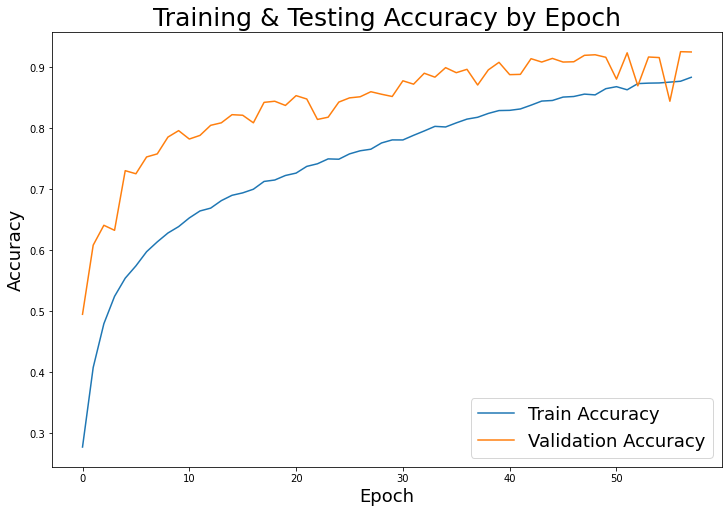

In [95]:
plot_hist(cnn_hist, "accuracy")

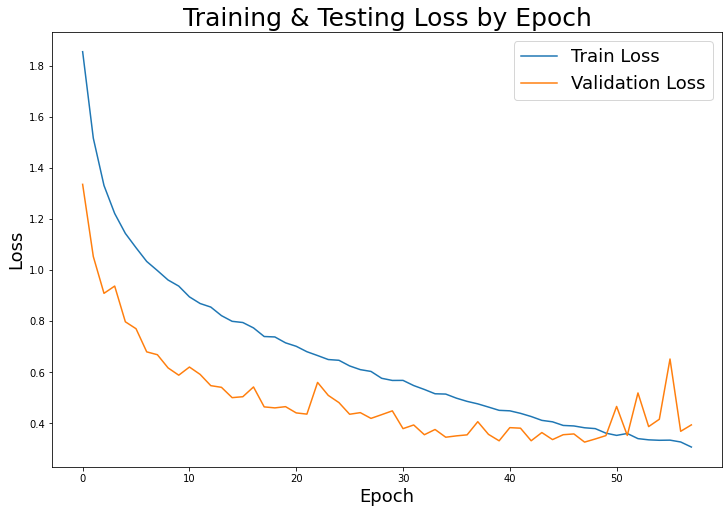

In [96]:
plot_hist(cnn_hist, 'loss')

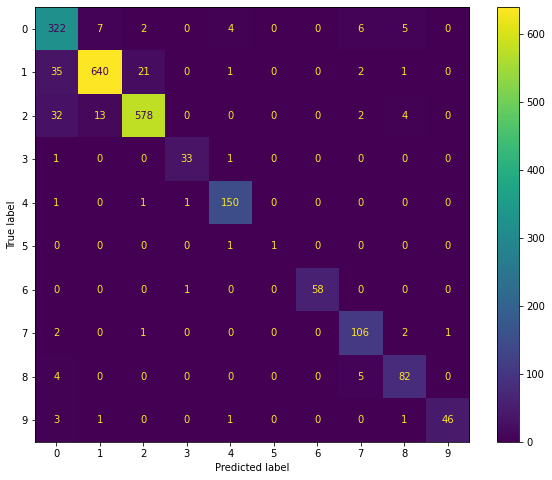

In [97]:
test_pred = cnn_hist.model.predict(test_images)
y_pred = np.argmax(test_pred, axis=1)

fig,ax = plt.subplots(figsize = (10,8))
ConfusionMatrixDisplay.from_predictions(test_labels.argmax(axis=1), y_pred, ax=ax);
# 1's show where predictions failed, diagonal is correct. 0's no error.

In [98]:
print('Accuracy Score : ' + str(accuracy_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1))))
print("F1 score of each class: ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = None) )
print("F1_score (micro): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'micro') ) #micro calculates positive and negative values globally:
                                                                                                                      #harmonic mean f1 score calc f1 score equally
print("F1_score (macro): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'macro') ) #macro, take the average of each class’s F-1 score:
print("F1_score (weighted): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'weighted') )
#The class F-1 scores are averaged by using the number of instances in a class as weights: its weighted by hte occurances

Accuracy Score : 0.9251950435979808
F1 score of each class:  [0.86327078 0.94048494 0.93831169 0.94285714 0.96463023 0.66666667
 0.99145299 0.90987124 0.88172043 0.92929293]
F1_score (micro):  0.9251950435979808
F1_score (macro):  0.9028559033430339
F1_score (weighted):  0.9261643195808894


In [ ]:
#SHUFFLED TRAINING DATA===============================================================

In [27]:
#Instantiate our CNN model
cnn_model = Sequential()

##Add a convolutional layer
cnn_model.add(Conv2D(filters = 16,  #number of filters
                     kernel_size = (3,3),#height/width of filters
                     activation = 'relu', #activation ftn
                     input_shape = train_images_v3[0].shape))  #shape of input (one image))

#Add a MaxPooling2D layer
cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling

#Add another convolutional layer
cnn_model.add(Conv2D(filters = 32,  #number of filters
                     kernel_size = (3,3),#height/width of filters
                     activation = 'relu', #activation ftn
                     input_shape = train_images_v3[0].shape)) #shape of input (one image))

#Add another pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling


#remember to flatten to go from the matrix (box) to the vertical line of nodes!
cnn_model.add(Flatten())

# Add a densely-connected layer with 128 neurons.
cnn_model.add(Dense(128, activation='relu'))

# Add a final layer with 10 neurons.
cnn_model.add(Dense(10, activation='softmax'))


cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 67, 67, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 33, 33, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 31, 31, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 7200)              0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [28]:
#compile the model
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

#FIT ON TRAINING DATA
cnn_hist = cnn_model.fit(train_images_v3_shuffled, train_labels_v3_encoded_shuffled,
                         batch_size=256, epochs = 100,
                         validation_data=(test_images, test_labels),
                         callbacks=EarlyStopping(patience=10))

Epoch 1/100
157/157 [==============================] - 4s 22ms/step - loss: 1.8452 - accuracy: 0.2811 - val_loss: 1.2667 - val_accuracy: 0.4865
Epoch 2/100
157/157 [==============================] - 3s 20ms/step - loss: 1.5346 - accuracy: 0.3945 - val_loss: 1.0861 - val_accuracy: 0.5686
Epoch 3/100
157/157 [==============================] - 3s 20ms/step - loss: 1.3610 - accuracy: 0.4655 - val_loss: 0.9969 - val_accuracy: 0.6035
Epoch 4/100
157/157 [==============================] - 3s 20ms/step - loss: 1.2446 - accuracy: 0.5138 - val_loss: 0.9050 - val_accuracy: 0.6645
Epoch 5/100
157/157 [==============================] - 3s 20ms/step - loss: 1.1589 - accuracy: 0.5513 - val_loss: 0.8804 - val_accuracy: 0.6705
Epoch 6/100
157/157 [==============================] - 3s 20ms/step - loss: 1.0884 - accuracy: 0.5778 - val_loss: 0.8196 - val_accuracy: 0.6902
Epoch 7/100
157/157 [==============================] - 3s 21ms/step - loss: 1.0379 - accuracy: 0.5975 - val_loss: 0.7606 - val_accuracy:

In [14]:
#Just to reverify that i got a huge good score of 91% for validation
#this score happens when I DO NOT SHUFFLE MY TRAINING SET

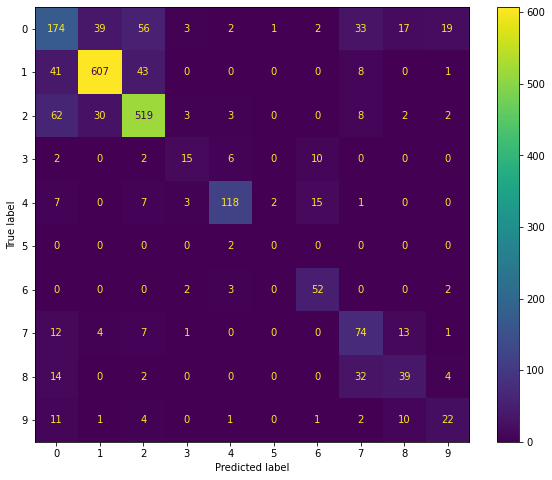

In [29]:
test_pred = cnn_hist.model.predict(test_images)
y_pred = np.argmax(test_pred, axis=1)

fig,ax = plt.subplots(figsize = (10,8))
ConfusionMatrixDisplay.from_predictions(test_labels.argmax(axis=1), y_pred, ax=ax);
# 1's show where predictions failed, diagonal is correct. 0's no error.

In [30]:
print('Accuracy Score : ' + str(accuracy_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1))))
print("F1 score of each class: ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = None) )
print("F1_score (micro): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'micro') ) #micro calculates positive and negative values globally:
                                                                                                                      #harmonic mean f1 score calc f1 score equally
print("F1_score (macro): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'macro') ) #macro, take the average of each class’s F-1 score:
print("F1_score (weighted): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'weighted') )
#The class F-1 scores are averaged by using the number of instances in a class as weights: its weighted by hte occurances

Accuracy Score : 0.7434603028912345
F1 score of each class:  [0.52017937 0.87907314 0.8179669  0.48387097 0.81944444 0.
 0.74820144 0.54814815 0.45348837 0.42718447]
F1_score (micro):  0.7434603028912345
F1_score (macro):  0.569755724797561
F1_score (weighted):  0.7439937746897082


In [ ]:
# train_images_v2 = tf.image.resize(train_images_v2, [100, 100])

In [ ]:
# train_images_v2.shape

TensorShape([43960, 100, 100, 3])

# **Paramter Tuning**

**BALANCED DATASET**

In [38]:
#Instantiate our CNN model
cnn_model = Sequential()

##Add a convolutional layer
cnn_model.add(Conv2D(filters = 16,  #number of filters
                     kernel_size = (3,3),#height/width of filters
                     activation = 'relu', #activation ftn
                     input_shape = train_images[0].shape))  #shape of input (one image))

#Add a MaxPooling2D layer
cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling

#Add another convolutional layer
cnn_model.add(Conv2D(filters = 32,  #number of filters
                     kernel_size = (3,3),#height/width of filters
                     activation = 'relu', #activation ftn
                     input_shape = train_images[0].shape)) #shape of input (one image))

#Add another pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling



cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))
cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))

cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))                      

cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))

cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))

cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))

cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))



#remember to flatten to go from the matrix (box) to the vertical line of nodes!
cnn_model.add(Flatten())

#add a batch normalization
cnn_model.add(BatchNormalization())

# Add a densely-connected layer with 1024 neurons.
cnn_model.add(Dense(1024, activation='relu', kernel_regularizer= l2(l2=0.15) ))

# Add a final layer with 10 neurons.
cnn_model.add(Dense(10, activation='softmax'))


cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 67, 67, 16)        448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 33, 33, 16)       0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 31, 31, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_21 (Conv2D)          (None, 13, 13, 32)        9248      
                                                                 
 conv2d_22 (Conv2D)          (None, 11, 11, 32)       

In [39]:
#compile the model
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

#FIT ON TRAINING DATA
cnn_hist = cnn_model.fit(train_images_v3_shuffled, train_labels_v3_encoded_shuffled,
                         batch_size=16, epochs = 100,
                         validation_data=(test_images, test_labels),
                         callbacks=EarlyStopping(patience=10))

Epoch 1/100
2500/2500 [==============================] - 17s 6ms/step - loss: 2.0031 - accuracy: 0.2441 - val_loss: 1.3859 - val_accuracy: 0.4401
Epoch 2/100
2500/2500 [==============================] - 15s 6ms/step - loss: 1.6515 - accuracy: 0.3539 - val_loss: 1.4196 - val_accuracy: 0.4663
Epoch 3/100
2500/2500 [==============================] - 14s 6ms/step - loss: 1.4912 - accuracy: 0.4302 - val_loss: 1.0152 - val_accuracy: 0.6595
Epoch 4/100
2500/2500 [==============================] - 13s 5ms/step - loss: 1.3893 - accuracy: 0.4781 - val_loss: 0.8422 - val_accuracy: 0.7022
Epoch 5/100
2500/2500 [==============================] - 13s 5ms/step - loss: 1.3033 - accuracy: 0.5138 - val_loss: 0.9300 - val_accuracy: 0.6746
Epoch 6/100
2500/2500 [==============================] - 13s 5ms/step - loss: 1.2171 - accuracy: 0.5480 - val_loss: 0.8517 - val_accuracy: 0.7201
Epoch 7/100
2500/2500 [==============================] - 13s 5ms/step - loss: 1.1624 - accuracy: 0.5735 - val_loss: 0.9029 -

In [ ]:
#TRACKER:
#WITH JUST 7 LAYERS ADDED WE GET TO A VAL ACCURACY OF 0.79
#just 2048 neurons 0.755
#7LAYERS + 2048 NEURONS .78

#okay it s awhole different score when my trained data isnt shuffled

**With different parameters (for the imbalanced training images):**

In [14]:
train_images_v2_shuffled.shape, train_labels_v2_encoded_shuffled.shape

((43960, 69, 69, 3), (43960, 10))

In [ ]:
#different kernel size

In [29]:
#Instantiate our CNN model
cnn_model = Sequential()

##Add a convolutional layer
cnn_model.add(Conv2D(filters = 16,  #number of filters
                     kernel_size = (2,2),#height/width of filters
                     activation = 'relu', #activation ftn
                     input_shape = train_images[0].shape))  #shape of input (one image))

#Add a MaxPooling2D layer
cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling

#Add another convolutional layer
cnn_model.add(Conv2D(filters = 32,  #number of filters
                     kernel_size = (2,2),#height/width of filters
                     activation = 'relu', #activation ftn
                     input_shape = train_images[0].shape)) #shape of input (one image))

#Add another pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling



cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))
cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))

cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))                      

cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))

cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))

cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))

cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))



#remember to flatten to go from the matrix (box) to the vertical line of nodes!
cnn_model.add(Flatten())

#add a batch normalization
cnn_model.add(BatchNormalization())

# Add a densely-connected layer with 1024 neurons.
cnn_model.add(Dense(1024, activation='relu', kernel_regularizer= l2(l2=0.15) ))

# Add a final layer with 10 neurons.
cnn_model.add(Dense(10, activation='softmax'))


cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 68, 68, 16)        208       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 34, 34, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 33, 33, 32)        2080      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 12, 32)       

In [30]:
#compile the model
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

#FIT ON TRAINING DATA
cnn_hist = cnn_model.fit(train_images_v2_shuffled, train_labels_v2_encoded_shuffled,
                         batch_size=16, epochs = 100,
                         validation_data=(test_images, test_labels),
                         callbacks=EarlyStopping(patience=10))

Epoch 1/100
2748/2748 [==============================] - 18s 6ms/step - loss: 2.0089 - accuracy: 0.3404 - val_loss: 1.5403 - val_accuracy: 0.3763
Epoch 2/100
2748/2748 [==============================] - 16s 6ms/step - loss: 1.4548 - accuracy: 0.4592 - val_loss: 1.1949 - val_accuracy: 0.5994
Epoch 3/100
2748/2748 [==============================] - 16s 6ms/step - loss: 1.3264 - accuracy: 0.5056 - val_loss: 1.0081 - val_accuracy: 0.6650
Epoch 4/100
2748/2748 [==============================] - 16s 6ms/step - loss: 1.2529 - accuracy: 0.5365 - val_loss: 0.9242 - val_accuracy: 0.6944
Epoch 5/100
2748/2748 [==============================] - 16s 6ms/step - loss: 1.1941 - accuracy: 0.5633 - val_loss: 0.8346 - val_accuracy: 0.7150
Epoch 6/100
2748/2748 [==============================] - 16s 6ms/step - loss: 1.1342 - accuracy: 0.5909 - val_loss: 0.7811 - val_accuracy: 0.7430
Epoch 7/100
2748/2748 [==============================] - 16s 6ms/step - loss: 1.0854 - accuracy: 0.6104 - val_loss: 0.7439 -

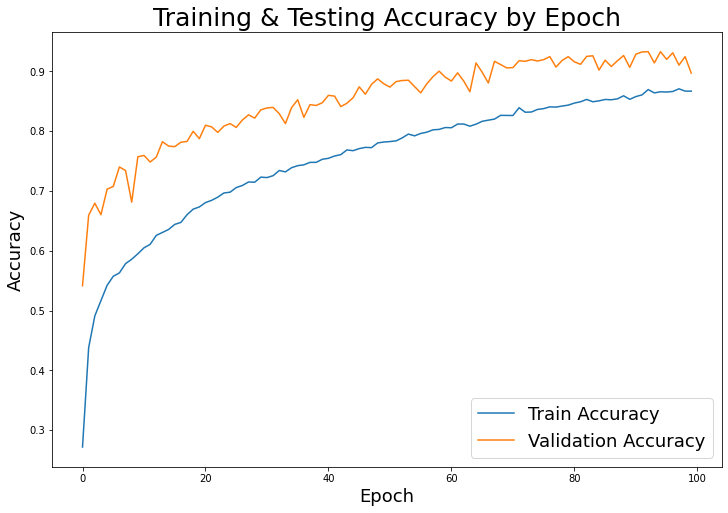

In [ ]:
plot_hist(cnn_hist, "accuracy")

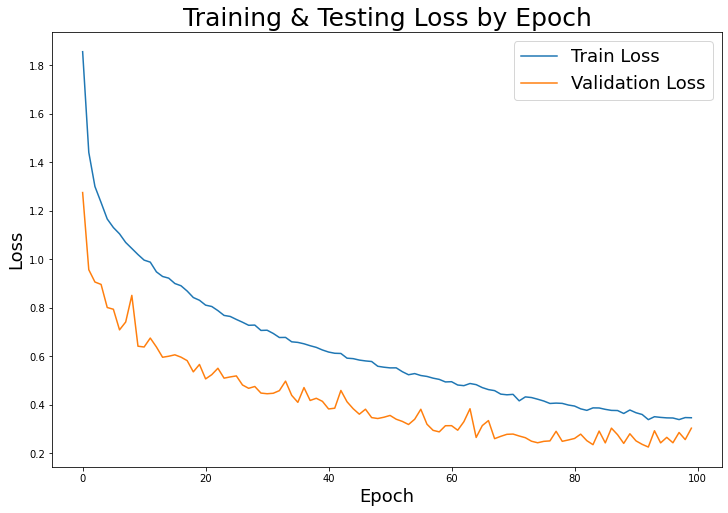

In [ ]:
plot_hist(cnn_hist, 'loss')

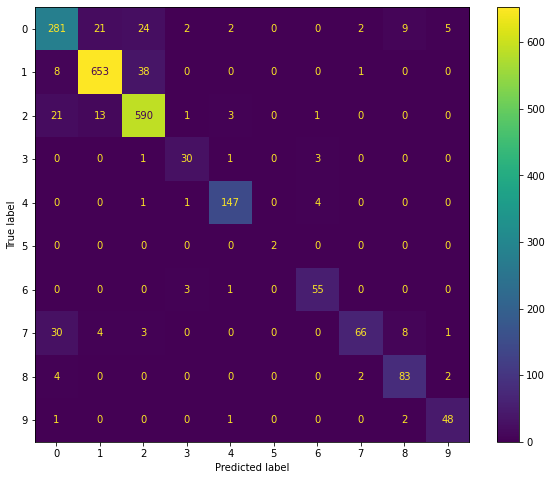

In [ ]:
test_pred = cnn_hist.model.predict(test_images)
y_pred = np.argmax(test_pred, axis=1)

fig,ax = plt.subplots(figsize = (10,8))
ConfusionMatrixDisplay.from_predictions(test_labels.argmax(axis=1), y_pred, ax=ax);
# 1's show where predictions failed, diagonal is correct. 0's no error.

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1))))
print("F1 score of each class: ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = None) )
print("F1_score (micro): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'micro') ) #micro calculates positive and negative values globally:
                                                                                                                      #harmonic mean f1 score calc f1 score equally
print("F1_score (macro): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'macro') ) #macro, take the average of each class’s F-1 score:
print("F1_score (weighted): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'weighted') )
#The class F-1 scores are averaged by using the number of instances in a class as weights: its weighted by hte occurances

Accuracy Score : 0.8972005507113354
F1 score of each class:  [0.81331404 0.93889288 0.91757387 0.83333333 0.95454545 1.
 0.90163934 0.72131148 0.86010363 0.88888889]
F1_score (micro):  0.8972005507113354
F1_score (macro):  0.8829602916300342
F1_score (weighted):  0.8955819278661816


In [ ]:
train_labels_v2_encoded.shape

(43960, 10)

**Parameters picked: 7 Conv layers, batch norm layer, 1 hidden layer with 1024 neurons with a kernel regularization of l2 = 0.15.. batch size of 16**

In [19]:
#Instantiate our CNN model
cnn_model = Sequential()

##Add a convolutional layer
cnn_model.add(Conv2D(filters = 16,  #number of filters
                     kernel_size = (3,3),#height/width of filters
                     activation = 'relu', #activation ftn
                     input_shape = train_images[0].shape))  #shape of input (one image))

#Add a MaxPooling2D layer
cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling

#Add another convolutional layer
cnn_model.add(Conv2D(filters = 32,  #number of filters
                     kernel_size = (3,3),#height/width of filters
                     activation = 'relu', #activation ftn
                     input_shape = train_images[0].shape)) #shape of input (one image))

#Add another pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,2))) #dimensions of region of pooling



cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))
cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))

cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))                      

cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))

cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))

cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))

cnn_model.add(Conv2D(filters = 32,  #number of filters
                      kernel_size = (3,3),#height/width of filters
                      activation = 'relu', #activation ftn
                      input_shape = train_images[0].shape )) #shape of input (one image))



#remember to flatten to go from the matrix (box) to the vertical line of nodes!
cnn_model.add(Flatten())

#add a batch normalization
cnn_model.add(BatchNormalization())

# Add a densely-connected layer with 1024 neurons.
cnn_model.add(Dense(1024, activation='relu', kernel_regularizer= l2(l2=0.15) ))

# Add a final layer with 10 neurons.
cnn_model.add(Dense(10, activation='softmax'))


cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 67, 67, 16)        448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 33, 33, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 32)       

In [20]:

#compile the model
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

#FIT ON TRAINING DATA
cnn_hist = cnn_model.fit(train_images_v2_shuffled, train_labels_v2_encoded_shuffled,
                         batch_size=16, epochs = 100,
                         validation_data=(test_images, test_labels),
                         callbacks=EarlyStopping(patience=10))

Epoch 1/100
2748/2748 [==============================] - 28s 6ms/step - loss: 1.8662 - accuracy: 0.3138 - val_loss: 1.2303 - val_accuracy: 0.5512
Epoch 2/100
2748/2748 [==============================] - 16s 6ms/step - loss: 1.5477 - accuracy: 0.4141 - val_loss: 1.1171 - val_accuracy: 0.6140
Epoch 3/100
2748/2748 [==============================] - 16s 6ms/step - loss: 1.4027 - accuracy: 0.4726 - val_loss: 0.9514 - val_accuracy: 0.6852
Epoch 4/100
2748/2748 [==============================] - 16s 6ms/step - loss: 1.3258 - accuracy: 0.5019 - val_loss: 0.9669 - val_accuracy: 0.6810
Epoch 5/100
2748/2748 [==============================] - 16s 6ms/step - loss: 1.2541 - accuracy: 0.5301 - val_loss: 0.8486 - val_accuracy: 0.7201
Epoch 6/100
2748/2748 [==============================] - 16s 6ms/step - loss: 1.1929 - accuracy: 0.5575 - val_loss: 1.6682 - val_accuracy: 0.4397
Epoch 7/100
2748/2748 [==============================] - 16s 6ms/step - loss: 1.1583 - accuracy: 0.5703 - val_loss: 0.8148 -

In [ ]:
#USE JOBLIN TO SAVE MY MODELS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!-----------------------
#save using joblib
joblib.dump(cnn_hist, "/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/cnn_aug_tuned_jl.h5" )

load_cnn = joblib.load("/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/cnn_aug_tuned_jl.h5")

INFO:tensorflow:Assets written to: ram://a78939f2-f952-492e-9eb6-ad898068cc78/assets


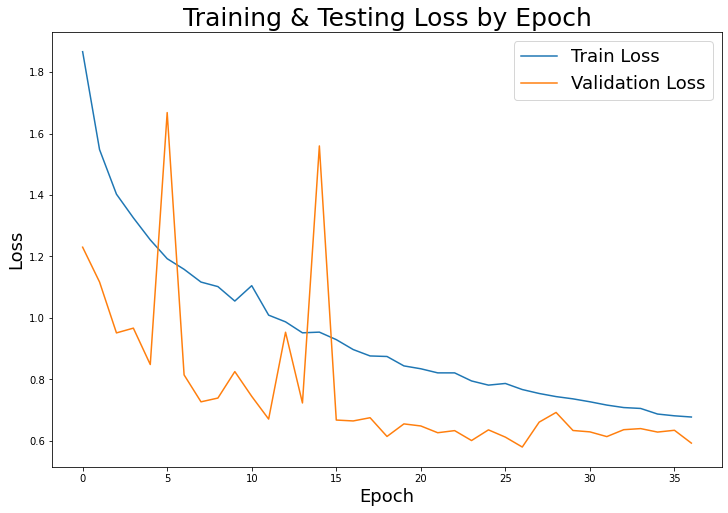

In [23]:
plot_hist(cnn_hist, 'loss')

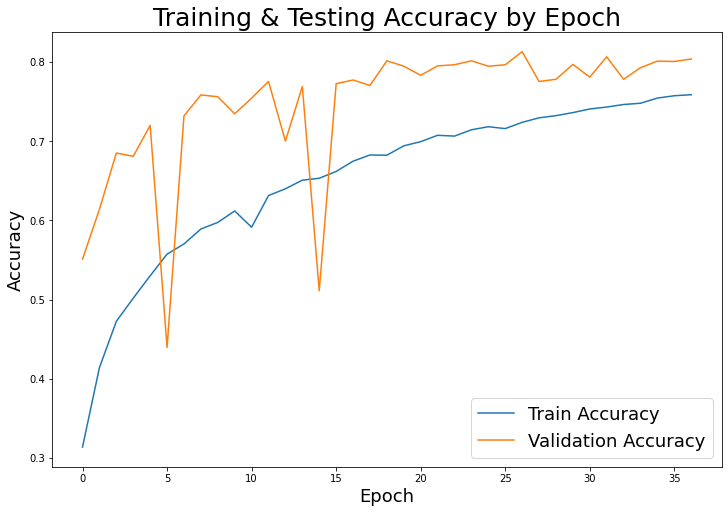

In [24]:
plot_hist(cnn_hist, "accuracy")

In [26]:
test_pred = cnn_hist.model.predict(test_images)
y_pred = np.argmax(cnn_hist.model.predict(test_images), axis=1)
y_pred

array([8, 0, 2, ..., 1, 2, 6])

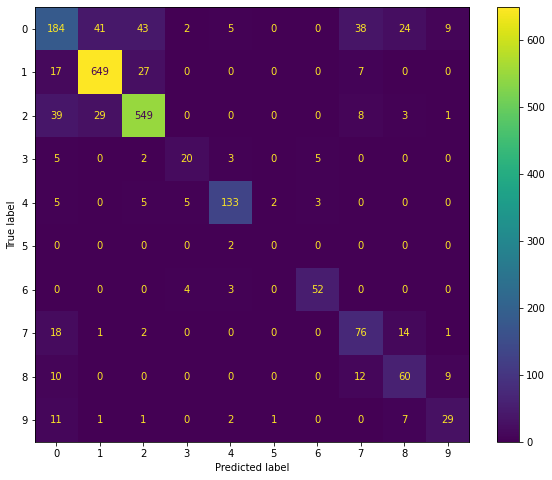

In [27]:

fig,ax = plt.subplots(figsize = (10,8))
ConfusionMatrixDisplay.from_predictions(test_labels.argmax(axis=1), y_pred, ax=ax);
# 1's show where predictions failed, diagonal is correct. 0's no error.

In [28]:
print('Accuracy Score : ' + str(accuracy_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1))))
print("F1 score of each class: ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = None) )
print("F1_score (micro): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'micro') ) #micro calculates positive and negative values globally:
                                                                                                                      #harmonic mean f1 score calc f1 score equally
print("F1_score (macro): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'macro') ) #macro, take the average of each class’s F-1 score:
print("F1_score (weighted): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'weighted') )
#The class F-1 scores are averaged by using the number of instances in a class as weights: its weighted by hte occurances

Accuracy Score : 0.8040385497934832
F1 score of each class:  [0.57952756 0.91344124 0.87281399 0.60606061 0.88372093 0.
 0.87394958 0.60079051 0.60301508 0.57425743]
F1_score (micro):  0.8040385497934832
F1_score (macro):  0.6507576919159106
F1_score (weighted):  0.8026315496664749


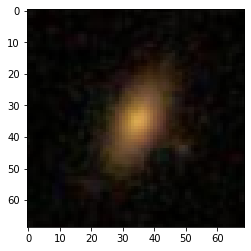

In [ ]:
plt.imshow(test_images[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


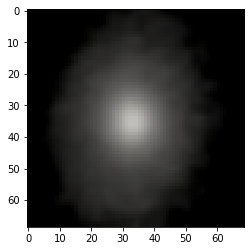

In [ ]:
plt.imshow(train_images_v2[0])

In [ ]:
train_labels.shape, test_labels.shape

((19606, 10), (2179, 10))

In [ ]:
train_images_v2.shape, test_images.shape

((43960, 69, 69, 3), (2179, 69, 69, 3))

With different parameters and regularization:

In [ ]:
#Instantiate our CNN model
cnn_model = Sequential()

##Add a convolutional layer
cnn_model.add(Conv2D(filters = 8,  #number of filters
                     kernel_size = (4,4),#height/width of filters
                     activation = 'relu', #activation ftn
                     input_shape = train_images_v2[0].shape))  #shape of input (one image))

#Add a MaxPooling2D layer
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=1)) #dimensions of region of pooling

#Add another convolutional layer
cnn_model.add(Conv2D(filters = 8,  #number of filters
                     kernel_size = (4,4),#height/width of filters
                     activation = 'relu', #activation ftn
                     input_shape = train_images_v2[0].shape)) #shape of input (one image))

#Add another pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=1)) #dimensions of region of pooling



cnn_model.add(Conv2D(filters = 8,  #number of filters
                      kernel_size = (4,4),#height/width of filters ef  sdf
                      activation = 'relu', #activation ftn
                      input_shape = train_images_v2[0].shape )) #shape of input (one image))
# cnn_model.add(Conv2D(filters = 8,  #number of filters
#                       kernel_size = (4,4),#height/width of filterssdasd
#                       activation = 'relu', #activation ftn
#                       input_shape = train_images_v2[0].shape )) #shape of input (one image))

# cnn_model.add(Conv2D(filters = 8,  #number of filters
#                       kernel_size = (4,4),#height/width of filters ssasd
#                       activation = 'relu', #activation ftn
#                       input_shape = train_images[0].shape )) #shape of input (one image))                      

# cnn_model.add(Conv2D(filters = 8,  #number of filters
#                       kernel_size = (4,4),#height/width of filters
#                       activation = 'relu', #activation ftn
#                       input_shape = train_images[0].shape )) #shape of input (one image))

# cnn_model.add(Conv2D(filters = 8,  #number of filters
#                       kernel_size = (4,4),#height/width of filters
#                       activation = 'relu', #activation ftn
#                       input_shape = train_images[0].shape )) #shape of input (one image))

# cnn_model.add(Conv2D(filters = 8,  #number of filters
#                       kernel_size = (4,4),#height/width of filters
#                       activation = 'relu', #activation ftn
#                       input_shape = train_images[0].shape )) #shape of input (one image))

# cnn_model.add(Conv2D(filters = 8,  #number of filters
#                       kernel_size = (4,4),#height/width of filters
#                       activation = 'relu', #activation ftn
#                       input_shape = train_images[0].shape )) #shape of input (one image))



#remember to flatten to go from the matrix (box) to the vertical line of nodes!
cnn_model.add(Flatten())

cnn_model.add(BatchNormalization(axis=1))

# Add a densely-connected layer with 1024 neurons.
cnn_model.add(Dense(2048, activation='relu', kernel_regularizer=l2(l2=0.15)))
cnn_model.add(Dropout(0.10))

# Add a densely-connected layer with 64 neurons.
cnn_model.add(Dense(1024, activation='relu'))#, kernel_regularizer= l2(l2=0.2)))

cnn_model.add(Dense(512, activation='relu'))#, kernel_regularizer= l2(l2=0.2)))

cnn_model.add(Dense(256, activation='relu'))#, kernel_regularizer= l2(l2=0.2)))

cnn_model.add(Dense(64, activation='relu', kernel_regularizer= l2(l2=0.2)))
cnn_model.add(Dropout(0.10))

cnn_model.add(Dense(32, activation='relu'))

# Add a final layer with 10 neurons.
cnn_model.add(Dense(10, activation='softmax'))


cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 66, 66, 8)         392       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 65, 65, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 62, 62, 8)         1032      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 61, 61, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 58, 58, 8)         1032      
                                                                 
 flatten_5 (Flatten)         (None, 26912)            

In [ ]:
#compile the model
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',  #keras.optimizers.SGD(learning_rate=0.001) ,
                  metrics=['accuracy'])

#FIT ON TRAINING DATA
cnn_hist = cnn_model.fit(train_images_v2, train_labels_v2_encoded,
                         batch_size=256, epochs = 150,  #256 batches was good
                         validation_data=(test_images, test_labels),
                         callbacks=EarlyStopping(patience=10))

In [ ]:
cnn_hist.model.predict(test_images)

array([[0.0911456 , 0.14253022, 0.1285813 , ..., 0.09109142, 0.09114564,
        0.09107799],
       [0.0911456 , 0.14253022, 0.1285813 , ..., 0.09109142, 0.09114564,
        0.09107799],
       [0.0911456 , 0.14253022, 0.1285813 , ..., 0.09109142, 0.09114564,
        0.09107799],
       ...,
       [0.0911456 , 0.14253022, 0.1285813 , ..., 0.09109142, 0.09114564,
        0.09107799],
       [0.0911456 , 0.14253022, 0.1285813 , ..., 0.09109142, 0.09114564,
        0.09107799],
       [0.0911456 , 0.14253022, 0.1285813 , ..., 0.09109142, 0.09114564,
        0.09107799]], dtype=float32)

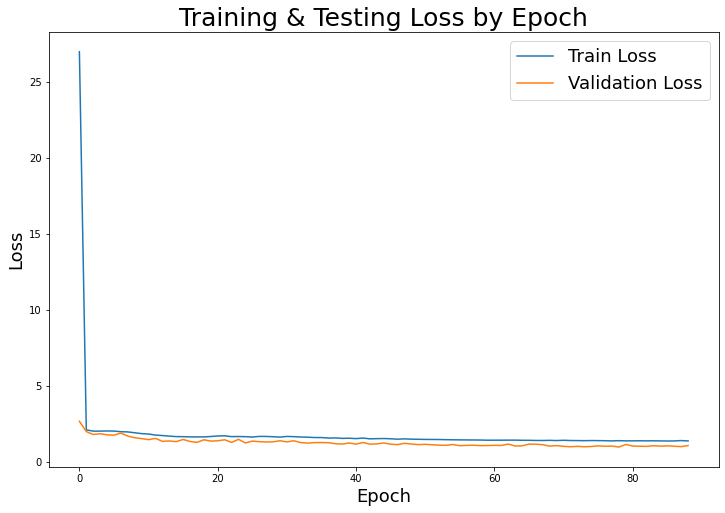

In [ ]:
plot_hist(cnn_hist, 'loss')

In [ ]:
#It is looking like adding too muhc optimization and tuned hyper parameters isnt the best

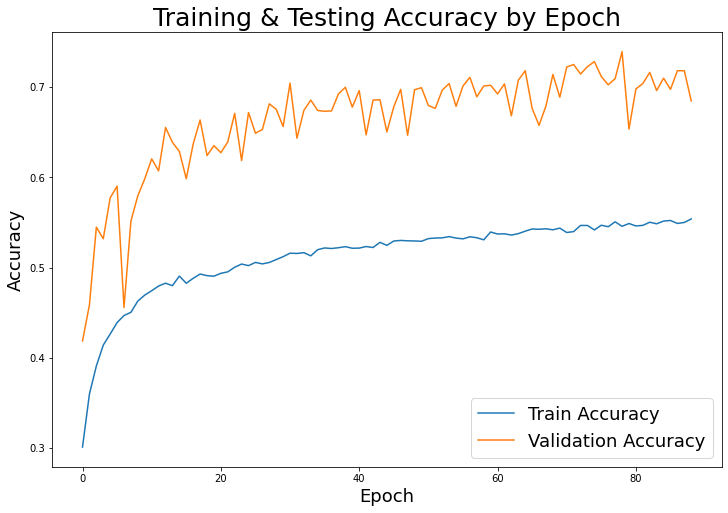

In [ ]:
plot_hist(cnn_hist, "accuracy")

In [ ]:
test_pred = cnn_hist.model.predict(test_images)
y_pred = np.argmax(cnn_hist.model.predict(test_images), axis=1)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

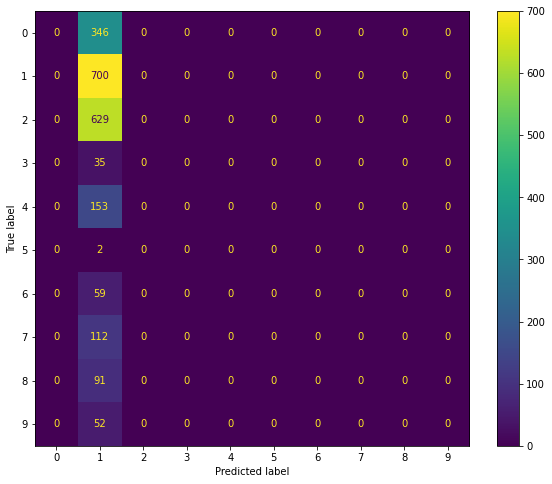

In [ ]:
fig,ax = plt.subplots(figsize = (10,8))
ConfusionMatrixDisplay.from_predictions(test_labels.argmax(axis=1), y_pred, ax=ax);
# 1's show where predictions failed, diagonal is correct. 0's no error.

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(test_labels.argmax(axis=1), y_pred)))
print("F1 score of each class: ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = None) )
print("F1_score (micro): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'micro') ) #micro calculates positive and negative values globally:
                                                                                                                      #harmonic mean f1 score calc f1 score equally
print("F1_score (macro): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'macro') ) #macro, take the average of each class’s F-1 score:
print("F1_score (weighted): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'weighted') )
#The class F-1 scores are averaged by using the number of instances in a class as weights: its weighted by hte occurances

Accuracy Score : 0.32124827902707664
F1 score of each class:  [0.         0.48627996 0.         0.         0.         0.
 0.         0.         0.         0.        ]
F1_score (micro):  0.32124827902707664
F1_score (macro):  0.04862799583188607
F1_score (weighted):  0.15621659973529253


In [ ]:
pd.DataFrame(np.argmax(train_labels_v2_encoded, axis=1)).value_counts()

1    6297
2    5663
0    4000
3    4000
4    4000
5    4000
6    4000
7    4000
8    4000
9    4000
dtype: int64

In [ ]:
pd.DataFrame(np.argmax(test_labels, axis=1)).value_counts()

1    700
2    629
0    346
4    153
7    112
8     91
6     59
9     52
3     35
5      2
dtype: int64

In [ ]:
#An option where i cna save all the images into a folder by their class(0 - 9) so that i can use ImageDataGenerator 
# im = np.array(Image.fromarray((class_9_images[467] * 255).astype(np.uint8)).resize((69, 69)).convert('RGB'))
# cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/class9img.png', im)

In [ ]:
# train_datagen = ImageDataGenerator(
#             rescale=None,
#             shear_range=0.2,
#             zoom_range=0.2,
#             horizontal_flip=True
# )

In [ ]:
#load_img('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/some_image.png')

In [ ]:
#saving each image into their folder pertaining to their class
# dont run again after the first time ... unless we need to change something
#this isnt fully saving all the images to my drive
# for i in range(len(labels_class)):
#   # print(labels_class[i])

#   if labels_class[i] == 0:
#     im = np.array(Image.fromarray((images_conv[i]).astype(np.uint8)).resize((69, 69)).convert('RGB'))
#     cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/Galaxy10/class_0/image{i}.jpeg", im)

#   elif labels_class[i] == 1:
#     im = np.array(Image.fromarray((images_conv[i]).astype(np.uint8)).resize((69, 69)).convert('RGB'))
#     cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/Galaxy10/class_1/image{i}.jpeg", im)

#   elif labels_class[i] == 2:
#     im = np.array(Image.fromarray((images_conv[i]).astype(np.uint8)).resize((69, 69)).convert('RGB'))
#     cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/Galaxy10/class_2/image{i}.jpeg", im)

#   elif labels_class[i] == 3:
#     im = np.array(Image.fromarray((images_conv[i]).astype(np.uint8)).resize((69, 69)).convert('RGB'))
#     cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/Galaxy10/class_3/image{i}.jpeg", im)

#   elif labels_class[i] == 4:
#     im = np.array(Image.fromarray((images_conv[i]).astype(np.uint8)).resize((69, 69)).convert('RGB'))
#     cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/Galaxy10/class_4/image{i}.jpeg", im)

#   elif labels_class[i] == 5:
#     im = np.array(Image.fromarray((images_conv[i]).astype(np.uint8)).resize((69, 69)).convert('RGB'))
#     cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/Galaxy10/class_5/image{i}.jpeg", im)

#   elif labels_class[i] == 6:
#     im = np.array(Image.fromarray((images_conv[i]).astype(np.uint8)).resize((69, 69)).convert('RGB'))
#     cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/Galaxy10/class_6/image{i}.jpeg", im)

#   elif labels_class[i] == 7:
#     im = np.array(Image.fromarray((images_conv[i]).astype(np.uint8)).resize((69, 69)).convert('RGB'))
#     cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/Galaxy10/class_7/image{i}.jpeg", im)

#   elif labels_class[i] == 8:
#     im = np.array(Image.fromarray((images_conv[i]).astype(np.uint8)).resize((69, 69)).convert('RGB'))
#     cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/Galaxy10/class_8/image{i}.jpeg", im)

#   elif labels_class[i] == 9:
#     im = np.array(Image.fromarray((images_conv[i]).astype(np.uint8)).resize((69, 69)).convert('RGB'))
#     cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/Galaxy10/class_9/image{i}.jpeg", im)


  # im = np.array(Image.fromarray((images_conv[i]).astype(np.uint8)).resize((69, 69)).convert('RGB'))
  # cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/some_image_{i}.jpeg", im)
